In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
import math
import os
import sys
import glob
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pandas.core.common import random_state
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,LSTM,SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
#all daily files in one dataframe
daily_df = pd.read_csv("daily_df.csv")
daily_df

day      LCLid       day.1  energy_median  energy_mean  \
0        2011-12-07  MAC000027  2011-12-07         0.1470     0.159880   
1        2011-12-08  MAC000027  2011-12-08         0.1705     0.193479   
2        2011-12-09  MAC000027  2011-12-09         0.1440     0.156771   
3        2011-12-10  MAC000027  2011-12-10         0.2415     0.264250   
4        2011-12-11  MAC000027  2011-12-11         0.2785     0.288438   
...             ...        ...         ...            ...          ...   
3510428  2013-05-11  MAC004883  2013-05-11         0.0480     0.065062   
3510429  2013-05-12  MAC004883  2013-05-12         0.0535     0.089146   
3510430  2013-05-13  MAC004883  2013-05-13         0.0465     0.052708   
3510431  2013-05-14  MAC004883  2013-05-14         0.0490     0.061833   
3510432  2013-05-15  MAC004883  2013-05-15         0.0540     0.065042   

         energy_max  energy_count  energy_std  energy_sum  energy_min  
0             0.408            25    0.062123       3.997       0.103  
1             0.459            48    0.077042       9.287       0.105  
2             0.365            48    0.051995       7.525       0.101  
3             0.814            48    0.135007      12.684       0.101  
4             0.540            48    0.112697      13.845       0.126  
...             ...           ...         ...         ...         ...  
3510428       0.155            48    0.032658       3.123       0.007  
3510429       0.805            48    0.125029       4.279       0.041  
3510430       0.120            48    0.022858       2.530       0.006  
3510431       0.112            48    0.025180       2.968       0.041  
3510432       0.189            48    0.030095       3.122       0.042  

[3510433 rows x 10 columns]

In [3]:
#setting to datetime index
daily_df.index = pd.to_datetime(daily_df["day"])

#using only columns that I will use for training
daily_df2 = daily_df[['LCLid', 'energy_sum','energy_mean','energy_std']]
daily_df2.head(5)

LCLid  energy_sum  energy_mean  energy_std
day                                                       
2011-12-07  MAC000027       3.997     0.159880    0.062123
2011-12-08  MAC000027       9.287     0.193479    0.077042
2011-12-09  MAC000027       7.525     0.156771    0.051995
2011-12-10  MAC000027      12.684     0.264250    0.135007
2011-12-11  MAC000027      13.845     0.288438    0.112697

## Preprocessing

In [4]:
#getting an overview on the data
daily_df2.describe()

energy_sum   energy_mean    energy_std
count  3.510403e+06  3.510403e+06  3.499102e+06
mean   1.012414e+01  2.117305e-01  1.726673e-01
std    9.128793e+00  1.908460e-01  1.531208e-01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    4.682000e+00  9.808333e-02  6.911626e-02
50%    7.815000e+00  1.632917e-01  1.327910e-01
75%    1.256900e+01  2.624583e-01  2.293124e-01
max    3.325560e+02  6.928250e+00  4.024569e+00

In [5]:
#checking for null values
daily_df2.isnull().sum()
#dropping null values
daily_df2=daily_df2.dropna()

In [6]:
#checking for if there are more null values
daily_df2.isnull().sum()

LCLid          0
energy_sum     0
energy_mean    0
energy_std     0
dtype: int64

In [7]:
#getting the ids with maximum amount of days or data and putting into another dataframe
ids_days = daily_df2["LCLid"].value_counts()
ids_days = pd.DataFrame(ids_days)

#getting the top 10 
ids_days.head(11)

LCLid
MAC000147    828
MAC000148    828
MAC000152    828
MAC000151    828
MAC000145    828
MAC000157    828
MAC000155    828
MAC000149    828
MAC000153    828
MAC000156    828
MAC000150    828

##### There are actually 11 houses that has 828 days of data but I am only will be using 10 of them.

In [8]:
#assigning the 10 houses into their respective data
MAC000145 = daily_df2.query('LCLid =="MAC000145"')
MAC000147 = daily_df2.query('LCLid =="MAC000147"')
MAC000149 = daily_df2.query('LCLid =="MAC000149"')
MAC000150 = daily_df2.query('LCLid =="MAC000150"')
MAC000156 = daily_df2.query('LCLid =="MAC000156"')
MAC000157 = daily_df2.query('LCLid =="MAC000157"')
MAC000151 = daily_df2.query('LCLid =="MAC000151"')
MAC000155 = daily_df2.query('LCLid =="MAC000155"')
MAC000152 = daily_df2.query('LCLid =="MAC000152"')
MAC000153 = daily_df2.query('LCLid =="MAC000153"')


### Plotting of daily datasets of 10 houses

In [9]:
#function that plots the daily total energy consumption per houses.
def plot_houseID(LCLid):
    LCLid["energy_sum"].plot(subplots=True, figsize=(12,5))
    plt.title("Daily Energy Consumption")
    plt.xlabel("Date")
    plt.ylabel("Energy Sum Per day.(kWh)")
    

Text(0, 0.5, 'Energy Sum Per day.(kWh)')

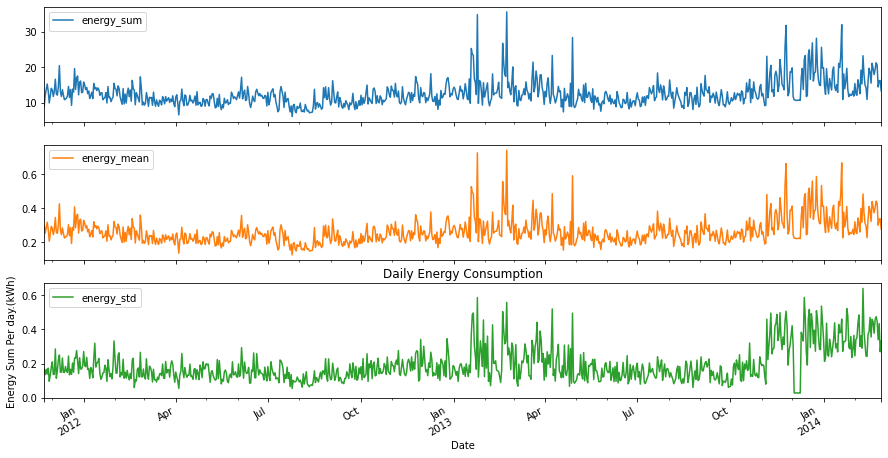

In [10]:
#getting trend visualization from a random house
MAC000145.plot(subplots=True, figsize=(15,8))
plt.title("Daily Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy Sum Per day.(kWh)")


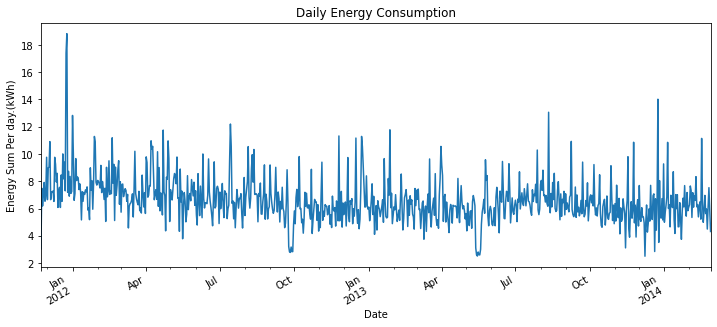

In [11]:
#Plot of daily consumption of house MAC000147
plot_houseID(MAC000147)

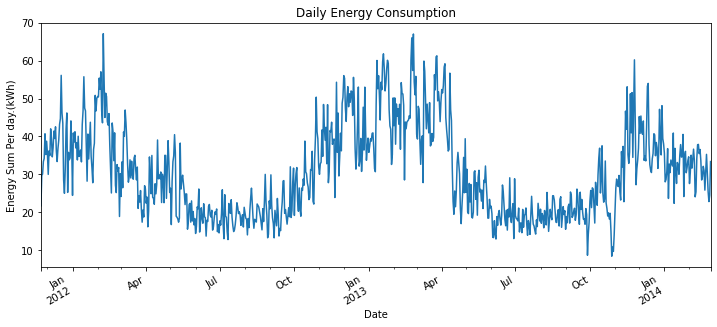

In [12]:
#Plot of daily consumption of house MAC000153
plot_houseID(MAC000153)

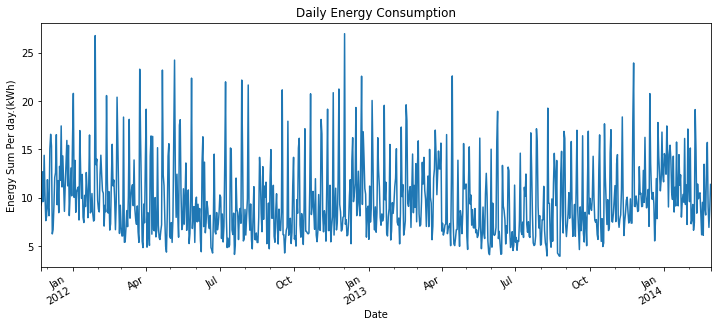

In [13]:
#Plot of daily consumption of house MAC000150
plot_houseID(MAC000150)

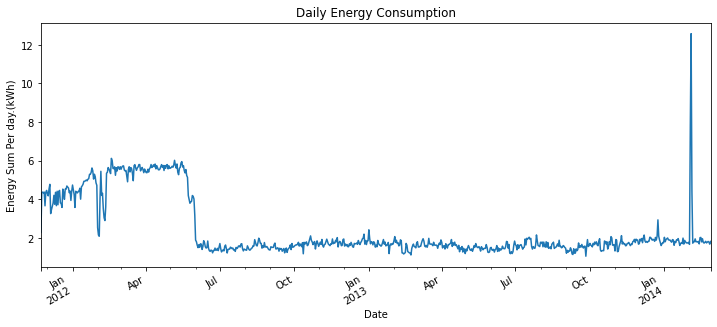

In [14]:
#Plot of daily consumption of house MAC000149
plot_houseID(MAC000149)

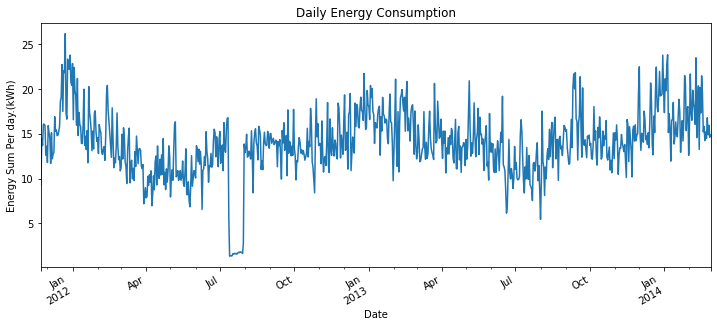

In [15]:
#Plot of daily consumption of house MAC000155
plot_houseID(MAC000155)

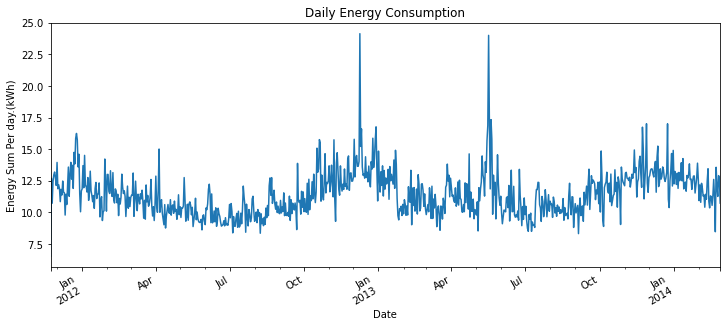

In [16]:
#Plot of daily consumption of house MAC000156
plot_houseID(MAC000156)

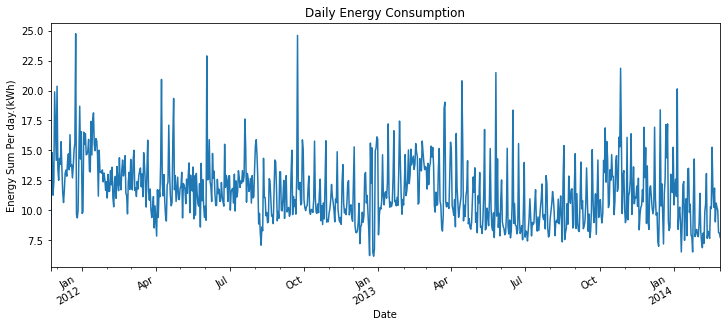

In [17]:
#Plot of daily consumption of house MAC000157
plot_houseID(MAC000157)

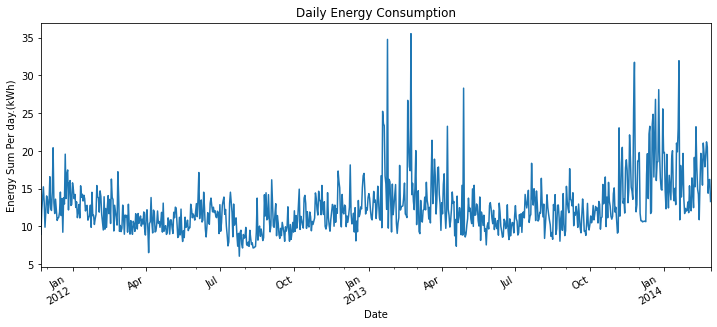

In [18]:
#Plot of daily consumption of house MAC000145
plot_houseID(MAC000145)

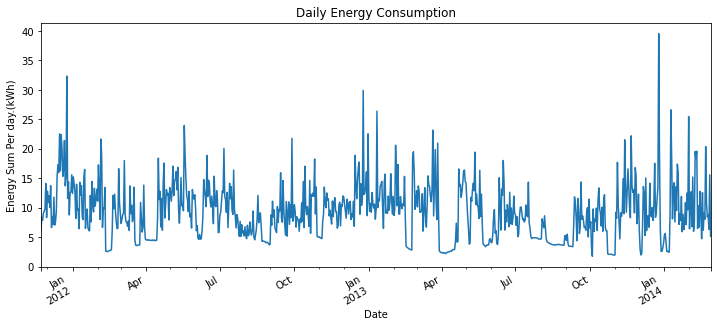

In [19]:
#Plot of daily consumption of house MAC000152
plot_houseID(MAC000152)

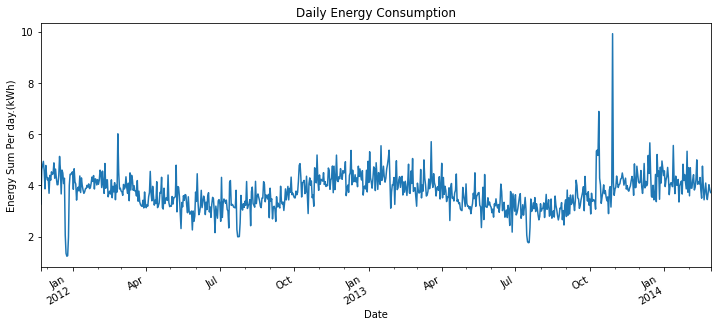

In [20]:
#Plot of daily consumption of house MAC000151
plot_houseID(MAC000151)

### Preparing for training set and test set


In [21]:
#function for training and test set
def training_data(house_number):
    x1,x2,y=house_number["energy_mean"],house_number["energy_std"],house_number["energy_sum"]
    x1,x2,y=np.array(x1),np.array(x2),np.array(y)
    x1,x2,y= x1.reshape(-1,1),x2.reshape(-1,1),y.reshape(-1,1)
    X=np.concatenate((x1,x2),axis =1) 
    return X,y 

In [22]:
#function for creating the X and Y sets
def X_Y_set(LCLid):
    #creating X and Y for desired household
    X,Y=training_data(LCLid)
    
    # division of trainingset and testset. 
    xtrain,xtest,ytrain,ytest = X[:-90],X[-90:],Y[:-90],Y[-90:]
    return xtrain,xtest,ytrain,ytest



In [23]:
#generating train and test set of 10 houses
xtrain_145,xtest_145,ytrain_145,ytest_145 = X_Y_set(MAC000145)
xtrain_153,xtest_153,ytrain_153,ytest_153 = X_Y_set(MAC000153)
xtrain_150,xtest_150,ytrain_150,ytest_150 = X_Y_set(MAC000150)
xtrain_151,xtest_151,ytrain_151,ytest_151 = X_Y_set(MAC000151)
xtrain_152,xtest_152,ytrain_152,ytest_152 = X_Y_set(MAC000152)
xtrain_157,xtest_157,ytrain_157,ytest_157 = X_Y_set(MAC000157)
xtrain_156,xtest_156,ytrain_156,ytest_156 = X_Y_set(MAC000156)
xtrain_155,xtest_155,ytrain_155,ytest_155 = X_Y_set(MAC000155)
xtrain_149,xtest_149,ytrain_149,ytest_149 = X_Y_set(MAC000149)
xtrain_147,xtest_147,ytrain_147,ytest_147 = X_Y_set(MAC000147)

In [24]:
#reviewing the shape of training data and test data of a random house.
xtrain_145.shape, ytrain_145.shape, xtest_145.shape,ytest_145.shape

((738, 2), (738, 1), (90, 2), (90, 1))

## Modelling

### Linear Regression Model

In [25]:
# defining linear regression model
lin_model = LinearRegression()

#fitting the training set
lin_model_145=lin_model.fit(xtrain_145,ytrain_145)
lin_model_153=lin_model.fit(xtrain_153,ytrain_153)
lin_model_150=lin_model.fit(xtrain_150,ytrain_150)
lin_model_151=lin_model.fit(xtrain_151,ytrain_151)
lin_model_152=lin_model.fit(xtrain_152,ytrain_152)
lin_model_157=lin_model.fit(xtrain_157,ytrain_157)
lin_model_156=lin_model.fit(xtrain_156,ytrain_156)
lin_model_155=lin_model.fit(xtrain_155,ytrain_155)
lin_model_149=lin_model.fit(xtrain_149,ytrain_149)
lin_model_147=lin_model.fit(xtrain_147,ytrain_147)

#predicting using the xtest
lin_pred_145=lin_model_145.predict(xtest_145)
lin_pred_153=lin_model_153.predict(xtest_153)
lin_pred_150=lin_model_150.predict(xtest_150)
lin_pred_151=lin_model_151.predict(xtest_151)
lin_pred_152=lin_model_152.predict(xtest_152)
lin_pred_157=lin_model_157.predict(xtest_157)
lin_pred_156=lin_model_156.predict(xtest_156)
lin_pred_155=lin_model_155.predict(xtest_155)
lin_pred_149=lin_model_149.predict(xtest_149)
lin_pred_147=lin_model_147.predict(xtest_147)

In [26]:
def Linear_Regression_plot(pred, test, LCLid= ""):
    plt.plot(test, label= 'Actual')
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(pred, label = "Linear Regression Predictions")
    plt.title("90 days Linear Regression Prediction Plot for {}".format(LCLid))
    plt.ylabel("Energy Consumption(kWh).")
    plt.xlabel("Days")
    plt.legend(loc= "upper left")
    plt.grid()
    plt.show()

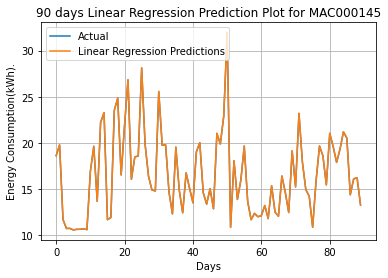

In [27]:
Linear_Regression_plot(lin_pred_145,ytest_145,"MAC000145")

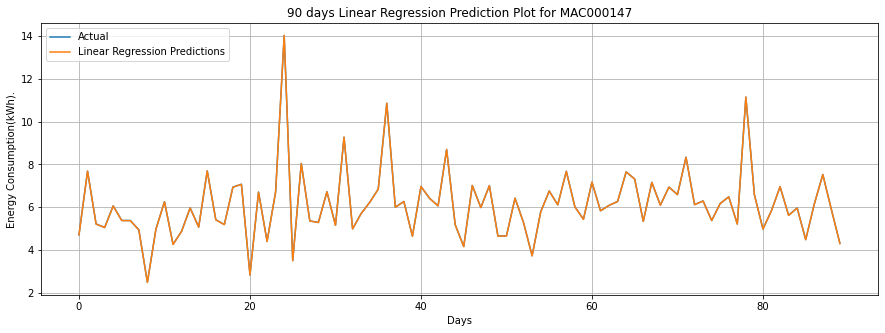

In [28]:
Linear_Regression_plot(lin_pred_147,ytest_147,"MAC000147")

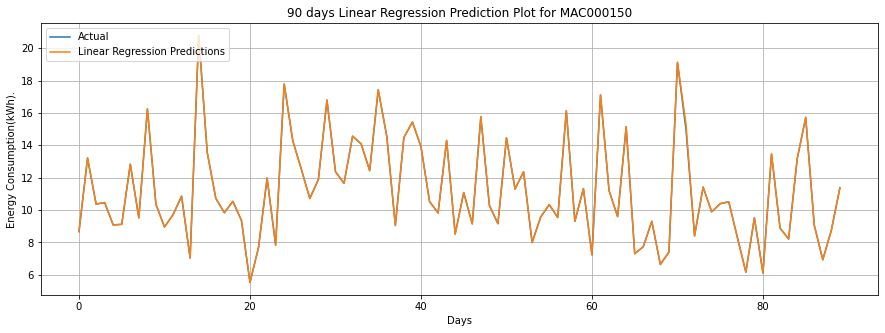

In [29]:
Linear_Regression_plot(lin_pred_150,ytest_150,"MAC000150")

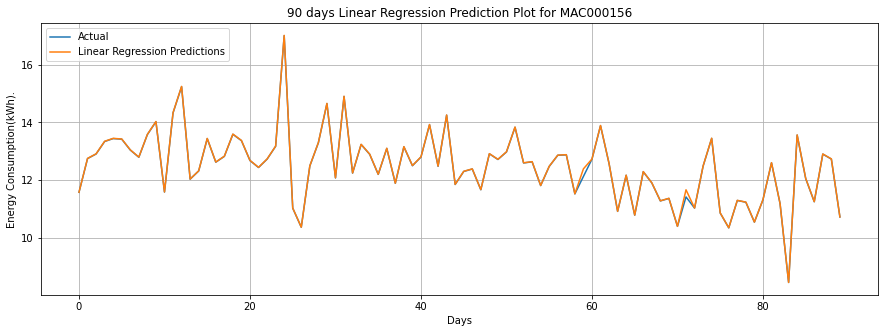

In [30]:
Linear_Regression_plot(lin_pred_156,ytest_156,"MAC000156")

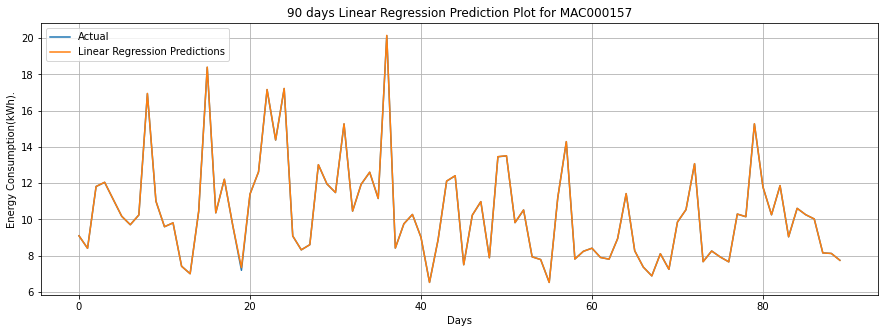

In [31]:
Linear_Regression_plot(lin_pred_157,ytest_157,"MAC000157")

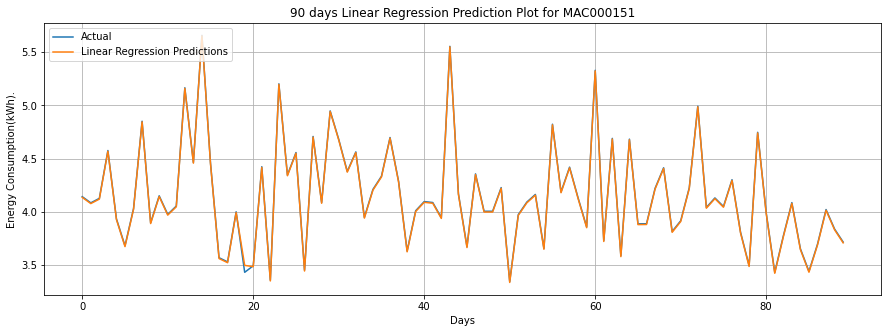

In [32]:
Linear_Regression_plot(lin_pred_151,ytest_151,"MAC000151")

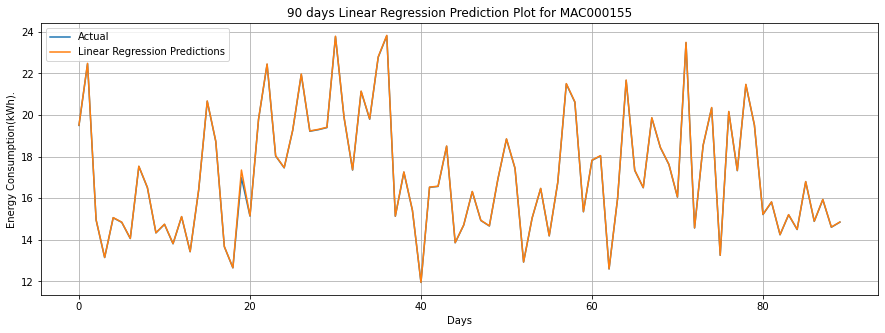

In [33]:
Linear_Regression_plot(lin_pred_155,ytest_155,"MAC000155")

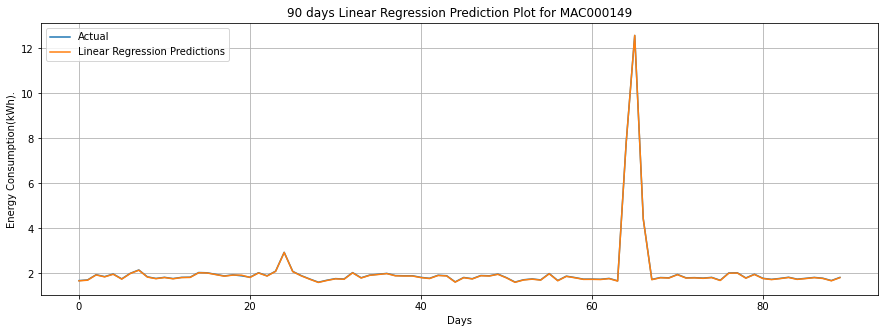

In [34]:
Linear_Regression_plot(lin_pred_149,ytest_149,"MAC000149")

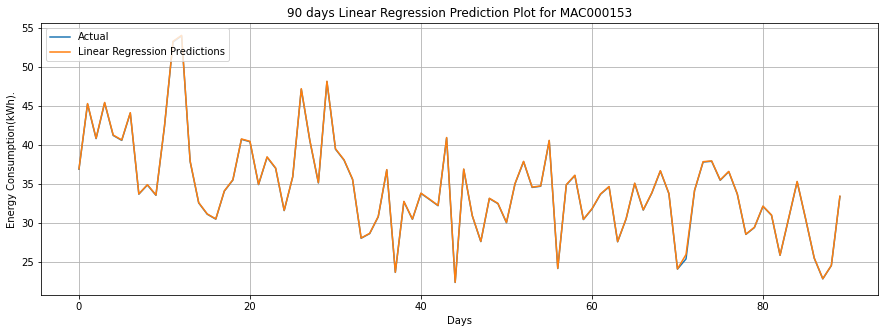

In [35]:
Linear_Regression_plot(lin_pred_153,ytest_153,"MAC000153")

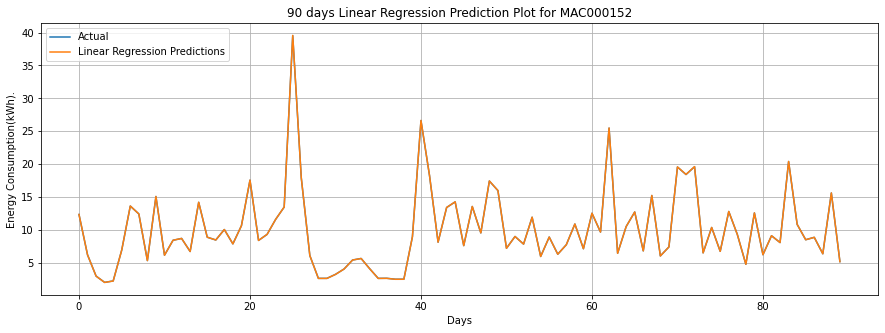

In [36]:
Linear_Regression_plot(lin_pred_152,ytest_152,"MAC000152")

### For Metrics

In [37]:
# Diffrent Metric function
def metric_calculation(pred,ytest): 
    # getting the Root Mean standard error
    rmse = sqrt(mean_squared_error(pred,ytest))
    
    #getting the Mean absolute percentage error(MAPE)
    mape = round((mean_absolute_error(ytest, pred)*100),2) 
    mape1 = str(mape) + '%'
    

    #getting the  Mean Square Error
    mse = np.square(np.subtract(ytest,pred)).mean()

    #calculating Mean Absolute Error
    mae = mean_absolute_error(ytest,pred)

    return rmse,mse,mae,mape1


In [38]:
#assigning the result for 10 houses
MAC000145_results = metric_calculation(lin_pred_145,ytest_145)
MAC000153_results = metric_calculation(lin_pred_153,ytest_153)
MAC000150_results = metric_calculation(lin_pred_150,ytest_150)
MAC000151_results = metric_calculation(lin_pred_151,ytest_151)
MAC000152_results = metric_calculation(lin_pred_152,ytest_152)
MAC000157_results = metric_calculation(lin_pred_157,ytest_157)
MAC000156_results = metric_calculation(lin_pred_156,ytest_156)
MAC000155_results = metric_calculation(lin_pred_155,ytest_155)
MAC000149_results = metric_calculation(lin_pred_149,ytest_149)
MAC000147_results = metric_calculation(lin_pred_147,ytest_147)


#function for the dataframe for all the results 
def metric_df(metric):
    house = pd.DataFrame(metric,columns=['Linear Regression'], index= ['RMSE','MSE','MAE','MAPE'])
    return house


#assigning dataframe results for 10 houses
house_145 = metric_df(MAC000145_results)
house_153 = metric_df(MAC000153_results)
house_150 = metric_df(MAC000150_results)
house_151 = metric_df(MAC000151_results)
house_152 = metric_df(MAC000152_results)
house_157 = metric_df(MAC000157_results)
house_156 = metric_df(MAC000156_results)
house_155 = metric_df(MAC000155_results)
house_149 = metric_df(MAC000149_results)
house_147 = metric_df(MAC000147_results)

### Metric Results for Linear Regression
##### Final results is in the end .

In [39]:
#MAC000145
house_145

Linear Regression
RMSE         0.0134649
MSE        0.000181304
MAE          0.0117008
MAPE             1.17%

In [40]:
#MAC000153
house_153

Linear Regression
RMSE         0.0715083
MSE         0.00511344
MAE          0.0445266
MAPE             4.45%

In [41]:
#MAC000150
house_150

Linear Regression
RMSE         0.0350495
MSE         0.00122847
MAE         0.00797303
MAPE              0.8%

### Random Forest

In [42]:
#Random Forest Approach
RF_model=RandomForestRegressor(n_estimators=100, max_features=2, random_state=1)

In [43]:
#fitting the model of house MAC000145
RF_model_145=RF_model.fit(xtrain_145,ytrain_145.ravel())

#predicting using the xtest
RF_pred_145=RF_model_145.predict(xtest_145)

In [44]:
#fitting and predicting the model of house MAC000153
RF_model_153=RF_model.fit(xtrain_153,ytrain_153.ravel())
RF_pred_153=RF_model_153.predict(xtest_153)


In [45]:
#fitting and predicting the model of house MAC000150
RF_model_150=RF_model.fit(xtrain_150,ytrain_150.ravel())
RF_pred_150=RF_model_150.predict(xtest_150)


In [46]:
#fitting and predicting the model of house MAC000151
RF_model_151=RF_model.fit(xtrain_151,ytrain_151.ravel())
RF_pred_151=RF_model_151.predict(xtest_151)


In [47]:
#fitting and predicting the model of house MAC000152
RF_model_152=RF_model.fit(xtrain_152,ytrain_152.ravel())
RF_pred_152=RF_model_152.predict(xtest_152)


In [48]:
#fitting and predicting the model of house MAC000157
RF_model_157=RF_model.fit(xtrain_157,ytrain_157.ravel())
RF_pred_157=RF_model_157.predict(xtest_157)


In [49]:
#fitting and predicting the model of house MAC000156
RF_model_156=RF_model.fit(xtrain_156,ytrain_156.ravel())
RF_pred_156=RF_model_156.predict(xtest_156)


In [50]:
#fitting and predicting the model of house MAC000155
RF_model_155=RF_model.fit(xtrain_155,ytrain_155.ravel())
RF_pred_155=RF_model_155.predict(xtest_155)


In [51]:
#fitting and predicting the model of house MAC000149
RF_model_149=RF_model.fit(xtrain_149,ytrain_149.ravel())
RF_pred_149=RF_model_149.predict(xtest_149)


In [52]:
#fitting and predicting the model of house MAC000147
RF_model_147=RF_model.fit(xtrain_147,ytrain_147.ravel())
RF_pred_147=RF_model_147.predict(xtest_147)

In [53]:
#Function for Plotting Random Forest Prediction.
def Random_Forest_plot(pred, test, LCLid= ""):
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(pred, label = "Random Forest Predictions")
    plt.plot(test, label= 'Actual')
    plt.title("90 days Random Forest Prediction Plot for {}".format(LCLid))
    plt.ylabel("Energy Consumption(kWh).")
    plt.xlabel("Days")
    plt.legend(loc= "upper left")
    plt.grid()
    plt.show()

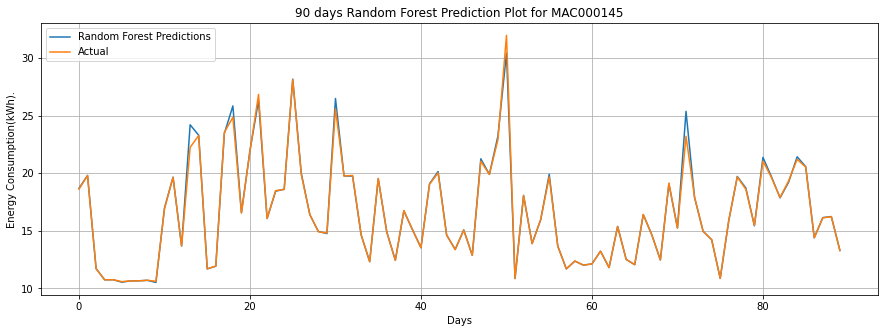

In [54]:
Random_Forest_plot(RF_pred_145,ytest_145,"MAC000145")

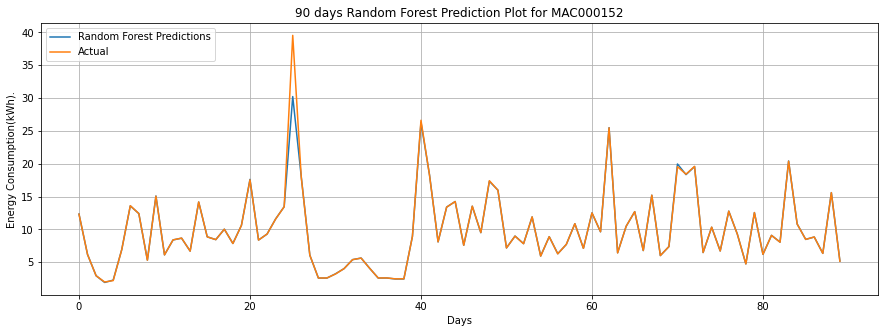

In [55]:
Random_Forest_plot(RF_pred_152,ytest_152,"MAC000152")

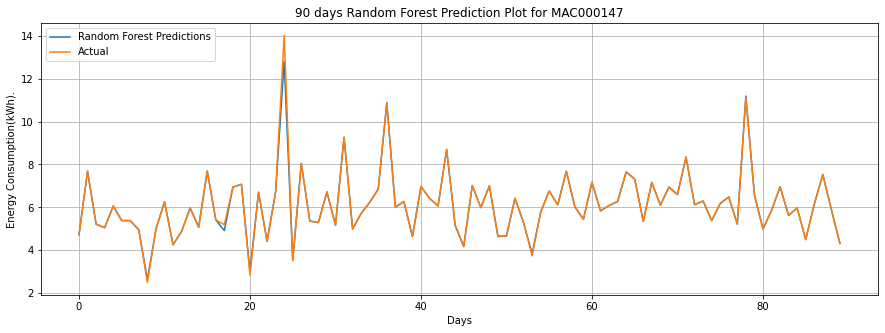

In [56]:
Random_Forest_plot(RF_pred_147,ytest_147,"MAC000147")

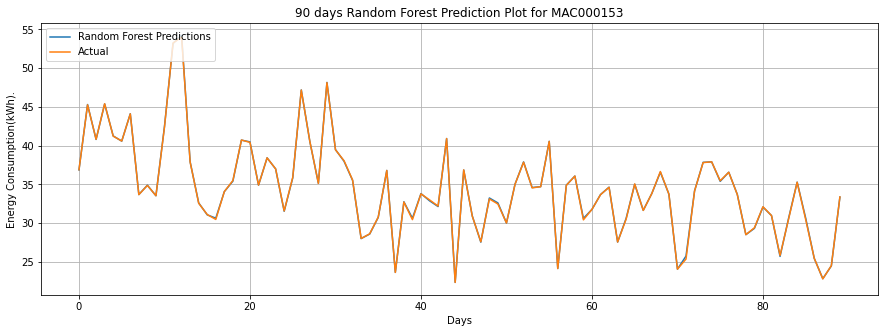

In [57]:
Random_Forest_plot(RF_pred_153,ytest_153,"MAC000153")

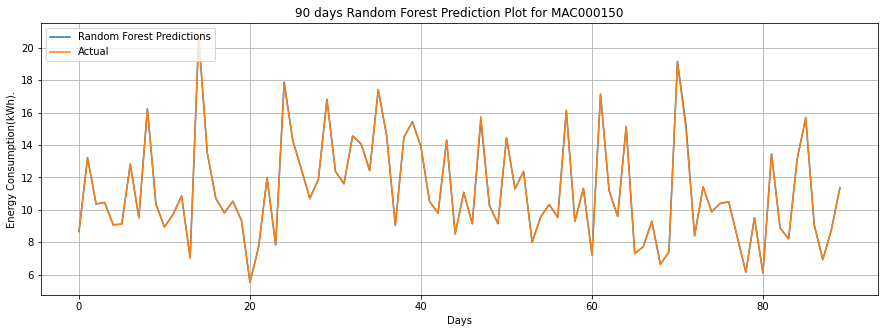

In [58]:
Random_Forest_plot(RF_pred_150,ytest_150,"MAC000150")

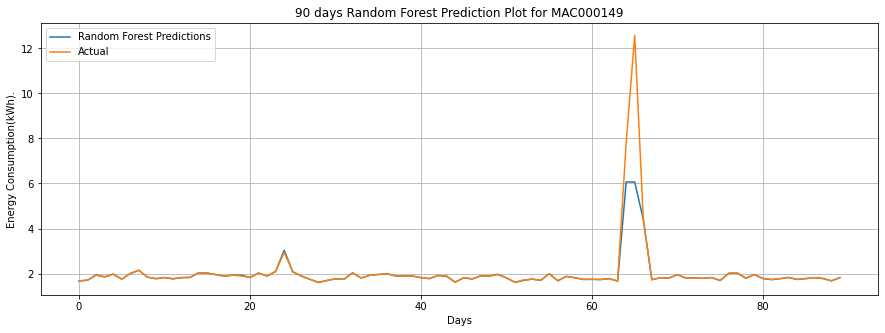

In [59]:
Random_Forest_plot(RF_pred_149,ytest_149,"MAC000149")

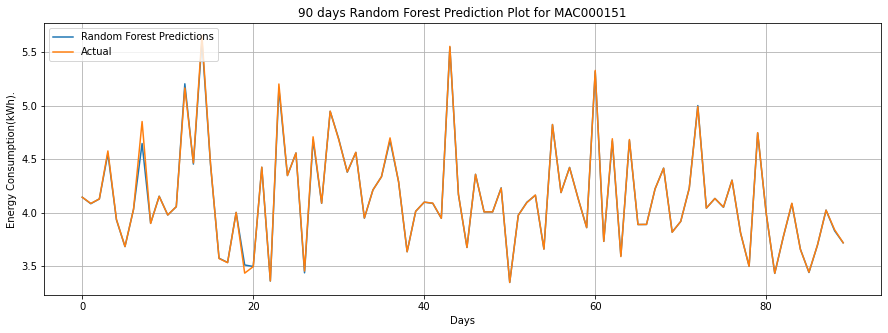

In [60]:
Random_Forest_plot(RF_pred_151,ytest_151,"MAC000151")

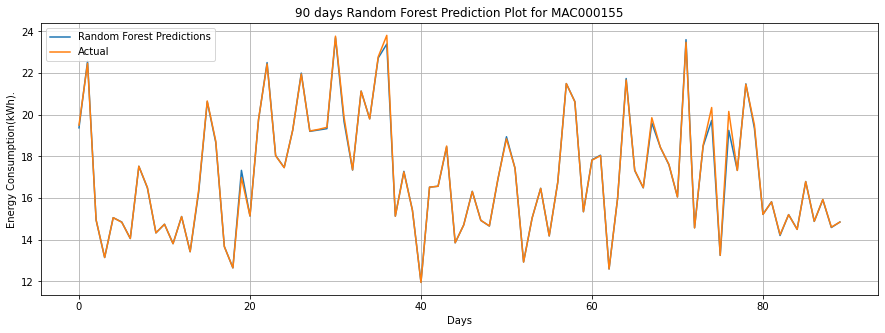

In [61]:
Random_Forest_plot(RF_pred_155,ytest_155,"MAC000155")

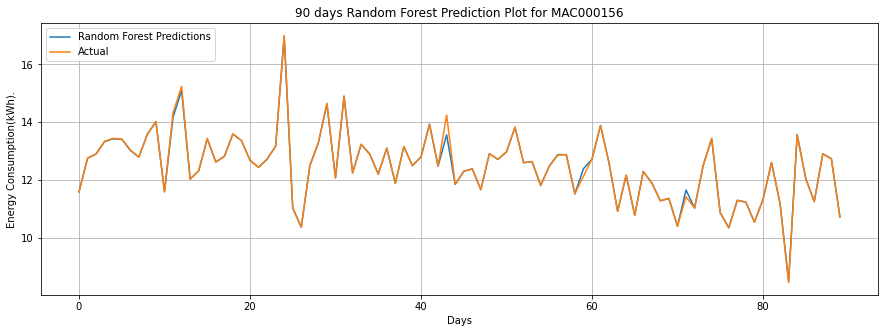

In [62]:
Random_Forest_plot(RF_pred_156,ytest_156,"MAC000156")

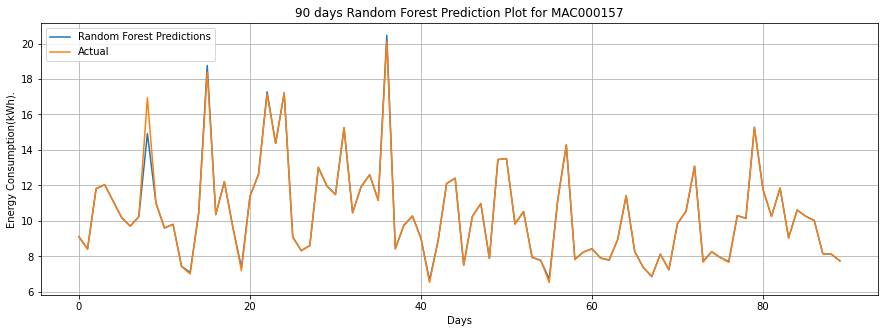

In [63]:
Random_Forest_plot(RF_pred_157,ytest_157,"MAC000157")

In [64]:
#assigning the result for 10 houses
MAC000145_results_RF = metric_calculation(RF_pred_145,ytest_145)
MAC000153_results_RF = metric_calculation(RF_pred_153,ytest_153)
MAC000150_results_RF = metric_calculation(RF_pred_150,ytest_150)
MAC000151_results_RF = metric_calculation(RF_pred_151,ytest_151)
MAC000152_results_RF = metric_calculation(RF_pred_152,ytest_152)
MAC000157_results_RF = metric_calculation(RF_pred_157,ytest_157)
MAC000156_results_RF = metric_calculation(RF_pred_156,ytest_156)
MAC000155_results_RF = metric_calculation(RF_pred_155,ytest_155)
MAC000149_results_RF = metric_calculation(RF_pred_149,ytest_149)
MAC000147_results_RF = metric_calculation(RF_pred_147,ytest_147)


#adding the result to their dataframe
house_145['Random Forest'] = MAC000145_results_RF
house_153['Random Forest'] = MAC000153_results_RF
house_150['Random Forest'] = MAC000150_results_RF
house_151['Random Forest'] = MAC000151_results_RF
house_152['Random Forest'] = MAC000152_results_RF
house_157['Random Forest'] = MAC000157_results_RF
house_156['Random Forest'] = MAC000156_results_RF
house_155['Random Forest'] = MAC000155_results_RF
house_149['Random Forest'] = MAC000149_results_RF
house_147['Random Forest'] = MAC000147_results_RF


#### Samples for result of metrics of Random Forest. 

In [65]:
house_150

Linear Regression Random Forest
RMSE         0.0350495     0.0469286
MSE         0.00122847       19.9857
MAE         0.00797303     0.0178673
MAPE              0.8%         1.79%

In [66]:
house_151

Linear Regression Random Forest
RMSE        0.00973448      0.025299
MSE        9.47602e-05      0.463761
MAE          0.0075436    0.00763522
MAPE             0.75%         0.76%

In [67]:
house_145

Linear Regression Random Forest
RMSE         0.0134649      0.387464
MSE        0.000181304       40.3155
MAE          0.0117008      0.127463
MAPE             1.17%        12.75%

In [68]:
house_157

Linear Regression Random Forest
RMSE         0.0166066       0.22182
MSE        0.000275781        14.866
MAE         0.00507612     0.0446113
MAPE             0.51%         4.46%

### MLP (Multi-layer Perceptron) Regressor

In [69]:
MLP_model = MLPRegressor(random_state=1, max_iter=1000)
#regr_predict=regr.predict(xtest)

#fitting the model set
MLP_model_145=MLP_model.fit(xtrain_145,ytrain_145.ravel())
MLP_pred_145=MLP_model_145.predict(xtest_145)


In [70]:
MLP_model_153=MLP_model.fit(xtrain_153,ytrain_153.ravel())
MLP_pred_153=MLP_model_153.predict(xtest_153)

In [71]:
MLP_model_145=MLP_model.fit(xtrain_145,ytrain_145.ravel())
MLP_pred_145=MLP_model_145.predict(xtest_145)

In [72]:
MLP_model_147=MLP_model.fit(xtrain_147,ytrain_147.ravel())
MLP_pred_147=MLP_model_147.predict(xtest_147)

In [73]:
MLP_model_149=MLP_model.fit(xtrain_149,ytrain_149.ravel())
MLP_pred_149=MLP_model_149.predict(xtest_149)

In [74]:
MLP_model_150=MLP_model.fit(xtrain_150,ytrain_150.ravel())
MLP_pred_150=MLP_model_150.predict(xtest_150)

In [75]:
MLP_model_151=MLP_model.fit(xtrain_151,ytrain_151.ravel())
MLP_pred_151=MLP_model_151.predict(xtest_151)

In [76]:
MLP_model_152=MLP_model.fit(xtrain_152,ytrain_152.ravel())
MLP_pred_152=MLP_model_152.predict(xtest_152)

In [77]:
MLP_model_155=MLP_model.fit(xtrain_155,ytrain_155.ravel())
MLP_pred_155=MLP_model_155.predict(xtest_155)

In [78]:
MLP_model_156=MLP_model.fit(xtrain_156,ytrain_156.ravel())
MLP_pred_156=MLP_model_156.predict(xtest_156)

/Users/smph/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [79]:
MLP_model_157=MLP_model.fit(xtrain_157,ytrain_157.ravel())
MLP_pred_157=MLP_model_157.predict(xtest_157)

In [80]:
def MLP_Regressor_plot(pred, test, LCLid= ""):
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(pred, label = "MLP Regressor  Predictions")
    plt.plot(test, label= 'Actual')
    plt.title("90 days MLP Regressor  Predictions Plot for {}".format(LCLid))
    plt.ylabel("Energy Consumption(kWh).")
    plt.xlabel("Days")
    plt.legend(loc= "upper left")
    plt.grid()
    plt.show()

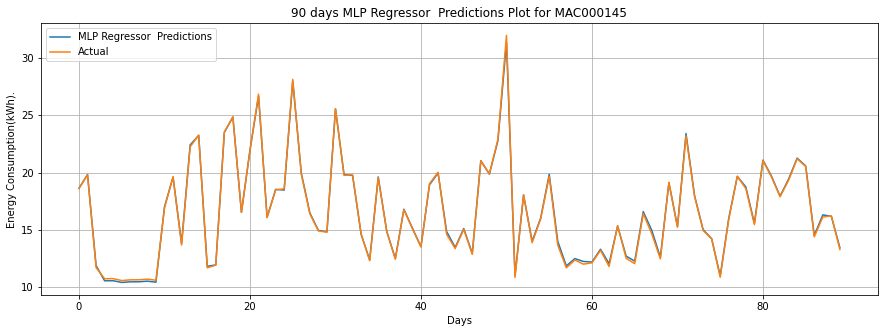

In [81]:
MLP_Regressor_plot(MLP_pred_145,ytest_145,"MAC000145")

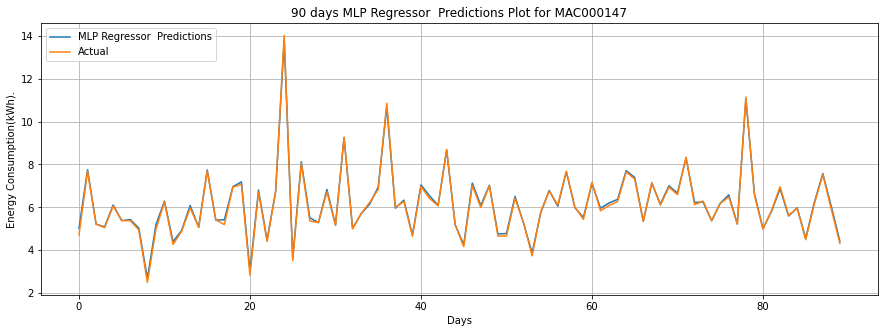

In [598]:
MLP_Regressor_plot(MLP_pred_147,ytest_147,"MAC000147")

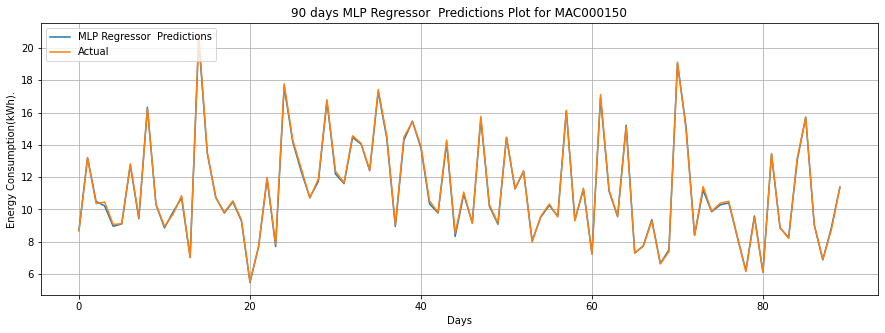

In [599]:
MLP_Regressor_plot(MLP_pred_150,ytest_150,"MAC000150")

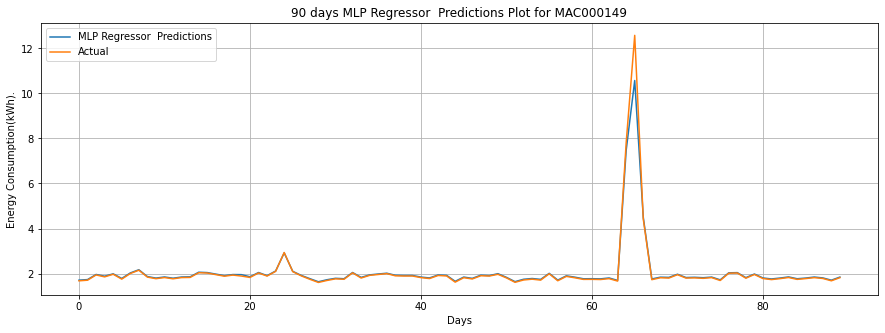

In [82]:
MLP_Regressor_plot(MLP_pred_149,ytest_149,"MAC000149")

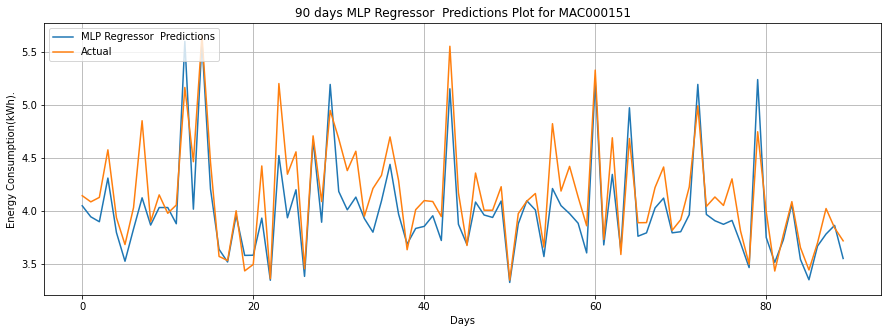

In [612]:
MLP_Regressor_plot(MLP_pred_151,ytest_151,"MAC000151")

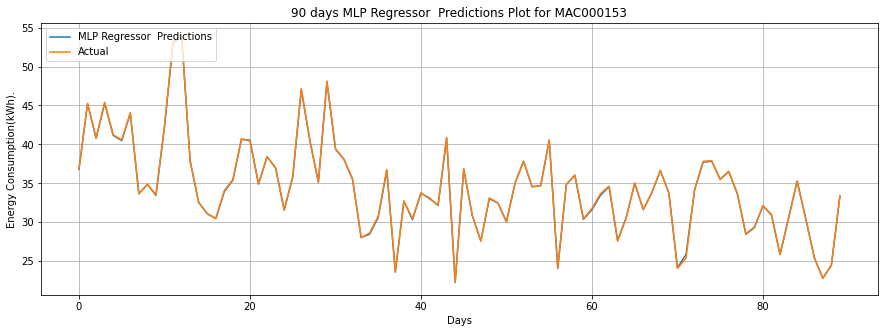

In [602]:
MLP_Regressor_plot(MLP_pred_153,ytest_153,"MAC000153")

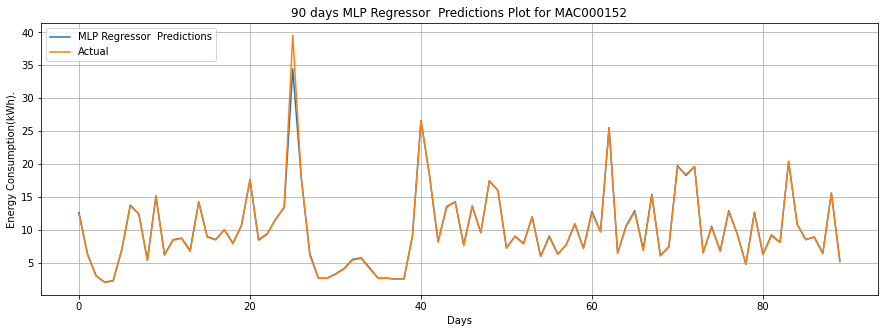

In [83]:
MLP_Regressor_plot(MLP_pred_152,ytest_152,"MAC000152")

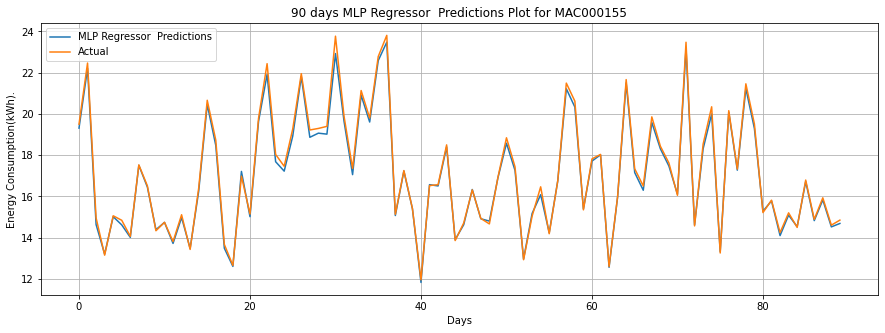

In [604]:
MLP_Regressor_plot(MLP_pred_155,ytest_155,"MAC000155")

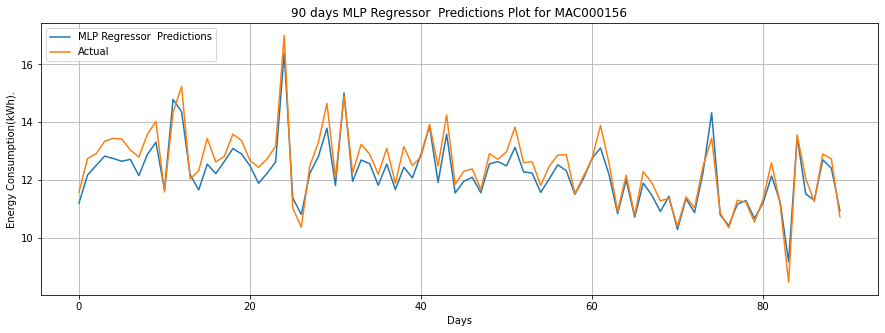

In [613]:
MLP_Regressor_plot(MLP_pred_156,ytest_156,"MAC000156")

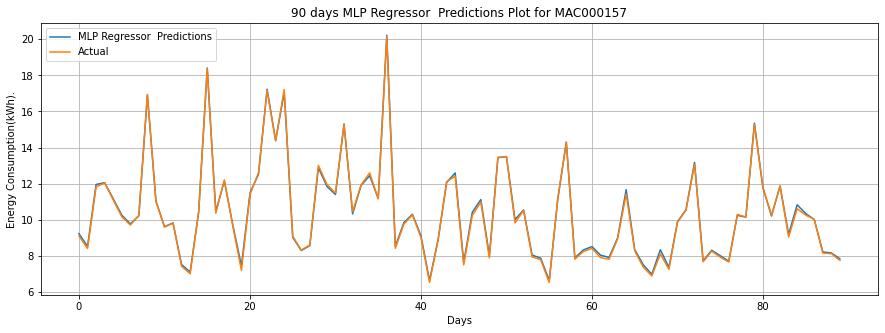

In [606]:
MLP_Regressor_plot(MLP_pred_157,ytest_157,"MAC000157")

In [614]:
#assigning the result for 10 houses
MAC000145_results_MLP = metric_calculation(MLP_pred_145,ytest_145)
MAC000153_results_MLP = metric_calculation(MLP_pred_153,ytest_153)
MAC000150_results_MLP = metric_calculation(MLP_pred_150,ytest_150)
MAC000151_results_MLP = metric_calculation(MLP_pred_151,ytest_151)
MAC000152_results_MLP = metric_calculation(MLP_pred_152,ytest_152)
MAC000157_results_MLP = metric_calculation(MLP_pred_157,ytest_157)
MAC000156_results_MLP = metric_calculation(MLP_pred_156,ytest_156)
MAC000155_results_MLP = metric_calculation(MLP_pred_155,ytest_155)
MAC000149_results_MLP = metric_calculation(MLP_pred_149,ytest_149)
MAC000147_results_MLP = metric_calculation(MLP_pred_147,ytest_147)


#adding the result to their dataframe
house_145['MLP Regressor'] = MAC000145_results_MLP
house_153['MLP Regressor'] = MAC000153_results_MLP
house_150['MLP Regressor'] = MAC000150_results_MLP
house_151['MLP Regressor'] = MAC000151_results_MLP
house_152['MLP Regressor'] = MAC000152_results_MLP
house_157['MLP Regressor'] = MAC000157_results_MLP
house_156['MLP Regressor'] = MAC000156_results_MLP
house_155['MLP Regressor'] = MAC000155_results_MLP
house_149['MLP Regressor'] = MAC000149_results_MLP
house_147['MLP Regressor'] = MAC000147_results_MLP

#### Samples of MLP Regressor Results.

In [615]:
house_145

Linear Regression Random Forest MLP Regressor
RMSE         0.0134649      0.387464      0.138777
MSE        0.000181304       40.3155       39.3234
MAE          0.0117008      0.127463      0.105781
MAPE             1.17%        12.75%        10.58%

In [616]:
house_153

Linear Regression Random Forest MLP Regressor
RMSE         0.0715083     0.0749467       0.09742
MSE         0.00511344       74.0175       73.6482
MAE          0.0445266     0.0452025     0.0693491
MAPE             4.45%         4.52%         6.93%

In [617]:
house_150

Linear Regression Random Forest MLP Regressor
RMSE         0.0350495     0.0469286     0.0995988
MSE         0.00122847       19.9857       19.8095
MAE         0.00797303     0.0178673      0.080271
MAPE              0.8%         1.79%         8.03%

In [618]:
house_151

Linear Regression Random Forest MLP Regressor
RMSE        0.00973448      0.025299      0.254433
MSE        9.47602e-05      0.463761      0.479731
MAE          0.0075436    0.00763522      0.197657
MAPE             0.75%         0.76%        19.77%

## XGBOOST

In [84]:
import xgboost as xgb

#Defining the model.
XGBoost_model = xgb.XGBRegressor(n_estimators=1000)

In [85]:
#Fitting the model set.
XGBoost_model_145=XGBoost_model.fit(xtrain_145,ytrain_145)

#Predicting using the xtest.
XGBoost_pred_145=XGBoost_model_145.predict(xtest_145)


In [86]:
# Fitting model and prediction of MAC000153.
XGBoost_model_153=XGBoost_model.fit(xtrain_153,ytrain_153)
XGBoost_pred_153=XGBoost_model_153.predict(xtest_153)


In [87]:
# Fitting model and prediction of MAC000150.
XGBoost_model_150=XGBoost_model.fit(xtrain_150,ytrain_150)
XGBoost_pred_150=XGBoost_model_150.predict(xtest_150)


In [88]:
# Fitting model and prediction of MAC000151.
XGBoost_model_151=XGBoost_model.fit(xtrain_151,ytrain_151)
XGBoost_pred_151=XGBoost_model_151.predict(xtest_151)


In [89]:
# Fitting model and prediction of MAC000152.
XGBoost_model_152=XGBoost_model.fit(xtrain_152,ytrain_152)
XGBoost_pred_152=XGBoost_model_152.predict(xtest_152)


In [90]:
# Fitting model and prediction of MAC000157.
XGBoost_model_157=XGBoost_model.fit(xtrain_157,ytrain_157)
XGBoost_pred_157=XGBoost_model_157.predict(xtest_157)


In [91]:
# Fitting model and prediction of MAC000156.
XGBoost_model_156=XGBoost_model.fit(xtrain_156,ytrain_156)
XGBoost_pred_156=XGBoost_model_156.predict(xtest_156)


In [92]:
# Fitting model and prediction of MAC000155.
XGBoost_model_155=XGBoost_model.fit(xtrain_155,ytrain_155)
XGBoost_pred_155=XGBoost_model_155.predict(xtest_155)


In [93]:
# Fitting model and prediction of MAC000149.
XGBoost_model_149=XGBoost_model.fit(xtrain_149,ytrain_149)
XGBoost_pred_149=XGBoost_model_149.predict(xtest_149)


In [94]:
# Fitting model and prediction of MAC000147.
XGBoost_model_147=XGBoost_model.fit(xtrain_147,ytrain_147)
XGBoost_pred_147=XGBoost_model_147.predict(xtest_147)

In [95]:
#Plot function for XGBosst regressor.
def XGBoost_Regressor_plot(pred, test, LCLid= ""):
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(pred, label = "XGBoost  Predictions")
    plt.plot(test, label= 'Actual')
    plt.title("90 days XGBoost  Predictions Plot for {}".format(LCLid))
    plt.ylabel("Energy Consumption(kWh).")
    plt.xlabel("Days")
    plt.legend(loc= "upper left")
    plt.grid()
    plt.show()

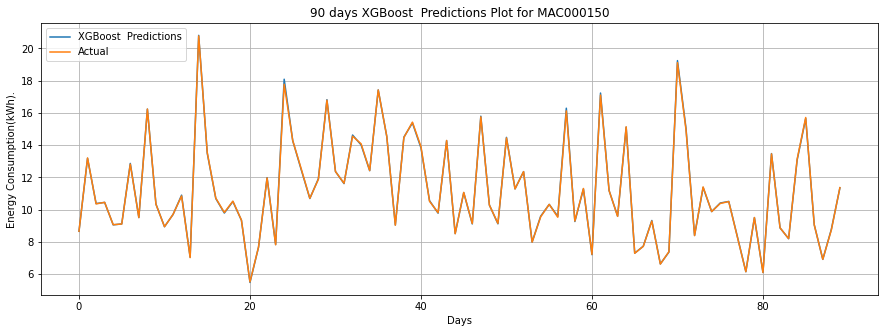

In [630]:
XGBoost_Regressor_plot(XGBoost_pred_150,ytest_150,"MAC000150")

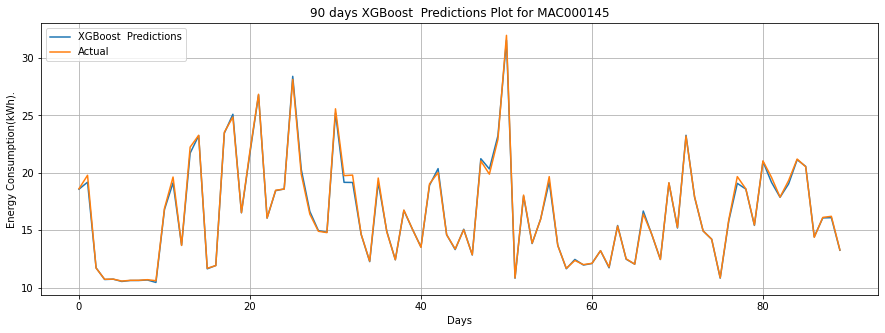

In [631]:
XGBoost_Regressor_plot(XGBoost_pred_145,ytest_145,"MAC000145")

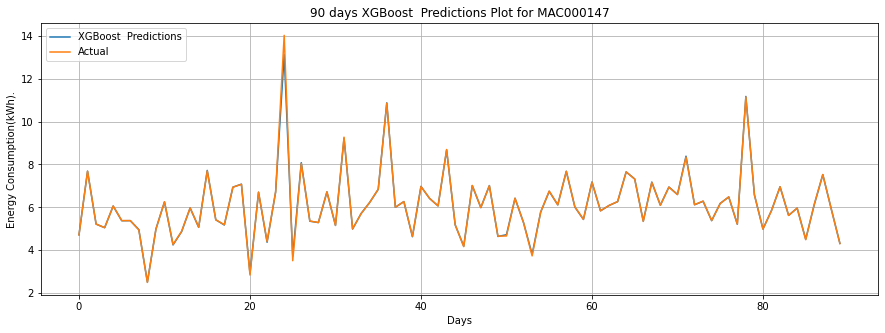

In [632]:
XGBoost_Regressor_plot(XGBoost_pred_147,ytest_147,"MAC000147")

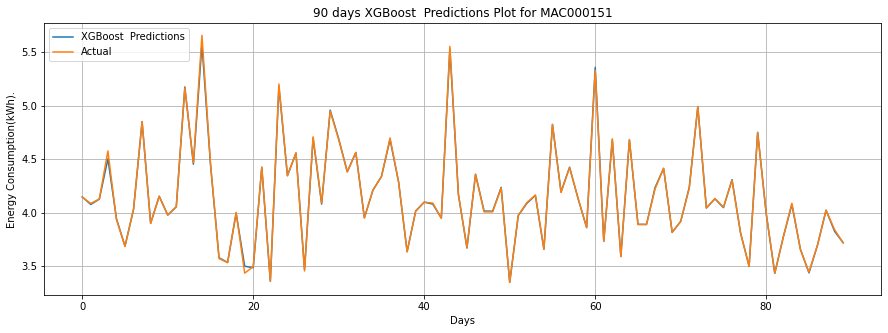

In [633]:
XGBoost_Regressor_plot(XGBoost_pred_151,ytest_151,"MAC000151")

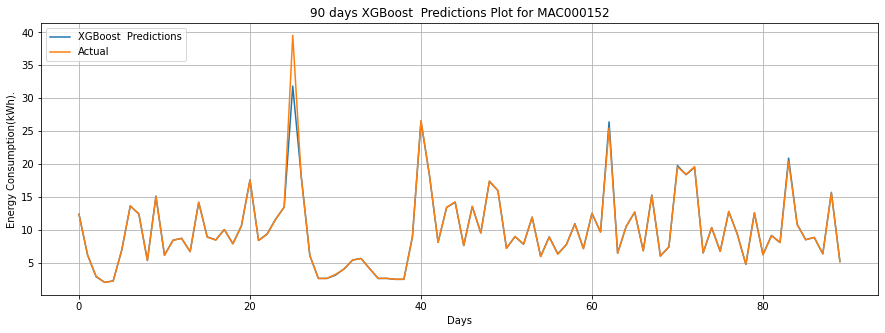

In [96]:
XGBoost_Regressor_plot(XGBoost_pred_152,ytest_152,"MAC000152")

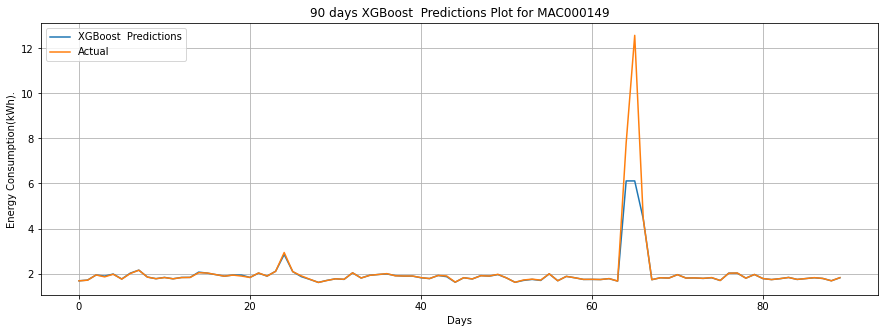

In [634]:
XGBoost_Regressor_plot(XGBoost_pred_149,ytest_149,"MAC000149")

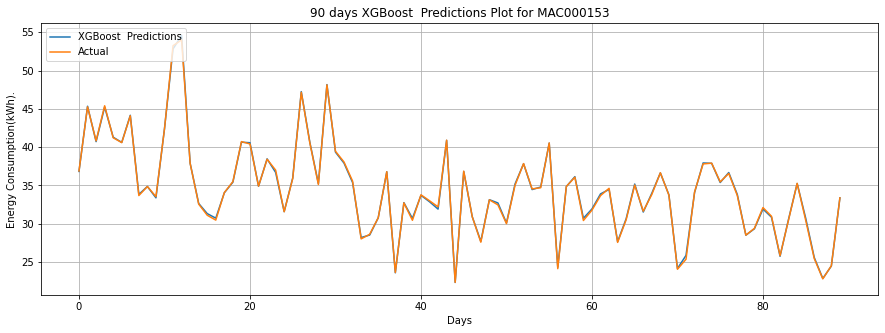

In [635]:
XGBoost_Regressor_plot(XGBoost_pred_153,ytest_153,"MAC000153")

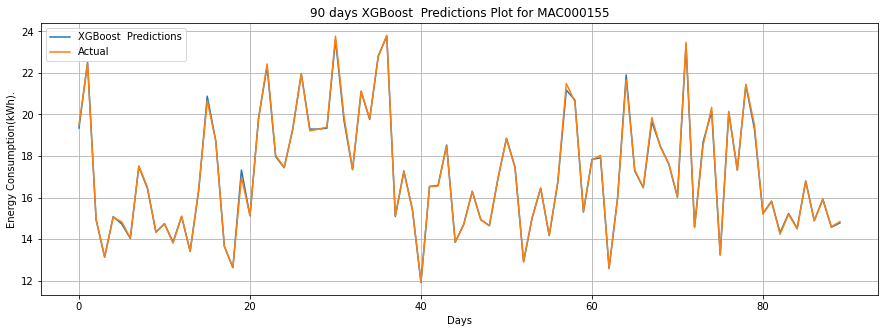

In [636]:
XGBoost_Regressor_plot(XGBoost_pred_155,ytest_155,"MAC000155")

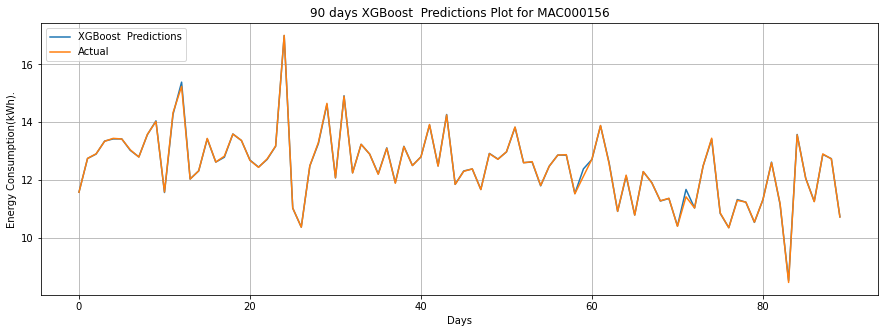

In [637]:
XGBoost_Regressor_plot(XGBoost_pred_156,ytest_156,"MAC000156")

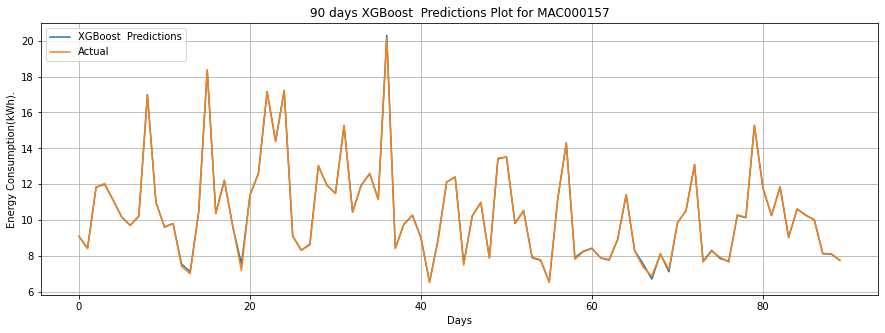

In [638]:
XGBoost_Regressor_plot(XGBoost_pred_157,ytest_157,"MAC000157")

In [639]:
#assigning the result for 10 houses
MAC000145_results_XGBoost = metric_calculation(XGBoost_pred_145,ytest_145)
MAC000153_results_XGBoost = metric_calculation(XGBoost_pred_153,ytest_153)
MAC000150_results_XGBoost = metric_calculation(XGBoost_pred_150,ytest_150)
MAC000151_results_XGBoost = metric_calculation(XGBoost_pred_151,ytest_151)
MAC000152_results_XGBoost = metric_calculation(XGBoost_pred_152,ytest_152)
MAC000157_results_XGBoost = metric_calculation(XGBoost_pred_157,ytest_157)
MAC000156_results_XGBoost = metric_calculation(XGBoost_pred_156,ytest_156)
MAC000155_results_XGBoost = metric_calculation(XGBoost_pred_155,ytest_155)
MAC000149_results_XGBoost = metric_calculation(XGBoost_pred_149,ytest_149)
MAC000147_results_XGBoost = metric_calculation(XGBoost_pred_147,ytest_147)


#adding the result to their dataframe
house_145['XGBoost Regressor'] = MAC000145_results_XGBoost
house_153['XGBoost Regressor'] = MAC000153_results_XGBoost
house_150['XGBoost Regressor'] = MAC000150_results_XGBoost
house_151['XGBoost Regressor'] = MAC000151_results_XGBoost
house_152['XGBoost Regressor'] = MAC000152_results_XGBoost
house_157['XGBoost Regressor'] = MAC000157_results_XGBoost
house_156['XGBoost Regressor'] = MAC000156_results_XGBoost
house_155['XGBoost Regressor'] = MAC000155_results_XGBoost
house_149['XGBoost Regressor'] = MAC000149_results_XGBoost
house_147['XGBoost Regressor'] = MAC000147_results_XGBoost

In [640]:
house_145

Linear Regression Random Forest MLP Regressor XGBoost Regressor
RMSE         0.0134649      0.387464      0.138777          0.210962
MSE        0.000181304       40.3155       39.3234           39.4187
MAE          0.0117008      0.127463      0.105781           0.12551
MAPE             1.17%        12.75%        10.58%            12.55%

In [641]:
house_153

Linear Regression Random Forest MLP Regressor XGBoost Regressor
RMSE         0.0715083     0.0749467       0.09742           0.15354
MSE         0.00511344       74.0175       73.6482           73.8071
MAE          0.0445266     0.0452025     0.0693491          0.112224
MAPE             4.45%         4.52%         6.93%            11.22%

In [642]:
house_157

Linear Regression Random Forest MLP Regressor XGBoost Regressor
RMSE         0.0166066       0.22182      0.099234         0.0601434
MSE        0.000275781        14.866       14.8385           14.9956
MAE         0.00507612     0.0446113     0.0813281         0.0321311
MAPE             0.51%         4.46%         8.13%             3.21%

# LSTM Model

In [333]:
hh_df =pd.concat(map(pd.read_csv,glob.glob(os.path.join("/Users/smph/Downloads/archive/halfhourly_dataset/halfhourly_dataset","block*.csv"))), ignore_index=True)
hh_df

/Users/smph/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


LCLid                         tstp energy(kWh/hh)
0          MAC000027  2011-12-07 11:30:00.0000000         0.185 
1          MAC000027  2011-12-07 12:00:00.0000000         0.155 
2          MAC000027  2011-12-07 12:30:00.0000000         0.147 
3          MAC000027  2011-12-07 13:00:00.0000000         0.164 
4          MAC000027  2011-12-07 13:30:00.0000000         0.187 
...              ...                          ...            ...
167817016  MAC004883  2013-05-15 21:30:00.0000000         0.106 
167817017  MAC004883  2013-05-15 22:00:00.0000000         0.111 
167817018  MAC004883  2013-05-15 22:30:00.0000000         0.058 
167817019  MAC004883  2013-05-15 23:00:00.0000000         0.042 
167817020  MAC004883  2013-05-15 23:30:00.0000000         0.042 

[167817021 rows x 3 columns]

### Data Preprocessing.

In [334]:
hh_df.index = pd.to_datetime(hh_df["tstp"],format='%Y.%m.%d %H:%M:%S')

In [335]:
hh_df.describe()

LCLid                         tstp energy(kWh/hh)
count   167817021                    167817021      167817021
unique       5566                        40405           9611
top     MAC000145  2012-11-19 19:00:00.0000000             0 
freq        39725                         5531        2001094

In [336]:
hh_df.isnull().sum()

LCLid             0
tstp              0
energy(kWh/hh)    0
dtype: int64

In [337]:
#Showing the 'Null' string values. 
hh_df[hh_df['energy(kWh/hh)'] == 'Null']

LCLid                         tstp energy(kWh/hh)
tstp                                                                      
2012-12-18 15:13:41  MAC000027  2012-12-18 15:13:41.0000000           Null
2012-12-18 15:15:33  MAC000406  2012-12-18 15:15:33.0000000           Null
2012-12-18 15:15:43  MAC000492  2012-12-18 15:15:43.0000000           Null
2012-12-18 15:15:45  MAC000512  2012-12-18 15:15:45.0000000           Null
2012-12-18 15:16:42  MAC000726  2012-12-18 15:16:42.0000000           Null
...                        ...                          ...            ...
2012-12-18 15:24:04  MAC003747  2012-12-18 15:24:04.0000000           Null
2012-12-18 15:22:47  MAC004693  2012-12-18 15:22:47.0000000           Null
2012-12-18 15:22:49  MAC004709  2012-12-18 15:22:49.0000000           Null
2012-12-18 15:15:51  MAC004744  2012-12-18 15:15:51.0000000           Null
2012-12-18 15:14:15  MAC004883  2012-12-18 15:14:15.0000000           Null

[5560 rows x 3 columns]

In [338]:
#dropping 'Null' values
hh_df=hh_df.drop(hh_df.index[hh_df['energy(kWh/hh)'] == 'Null'])

In [339]:
#checking if there are more 'Null' values
hh_df[hh_df['energy(kWh/hh)'] == 'Null']

Empty DataFrame
Columns: [LCLid, tstp, energy(kWh/hh)]
Index: []

In [657]:
# Finding the 0 energy.
hh_df[hh_df['energy(kWh/hh)'] == 0]

LCLid                         tstp  energy(kWh/hh)
tstp                                                                       
2013-03-29 11:30:00  MAC000512  2013-03-29 11:30:00.0000000             0.0
2013-03-29 12:00:00  MAC000512  2013-03-29 12:00:00.0000000             0.0
2013-04-07 03:30:00  MAC000512  2013-04-07 03:30:00.0000000             0.0
2013-04-07 04:30:00  MAC000512  2013-04-07 04:30:00.0000000             0.0
2013-04-07 06:00:00  MAC000512  2013-04-07 06:00:00.0000000             0.0
...                        ...                          ...             ...
2013-12-20 15:30:00  MAC004693  2013-12-20 15:30:00.0000000             0.0
2013-12-20 16:00:00  MAC004693  2013-12-20 16:00:00.0000000             0.0
2013-11-21 13:30:00  MAC004744  2013-11-21 13:30:00.0000000             0.0
2013-11-21 14:00:00  MAC004744  2013-11-21 14:00:00.0000000             0.0
2013-11-21 14:30:00  MAC004744  2013-11-21 14:30:00.0000000             0.0

[2001552 rows x 3 columns]

In [340]:
#Converting to numeric values.
hh_df['energy(kWh/hh)'] = pd.to_numeric(hh_df['energy(kWh/hh)'], downcast="float")

<ipython-input-340-7a9f0d1b76c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh_df['energy(kWh/hh)'] = pd.to_numeric(hh_df['energy(kWh/hh)'], downcast="float")


In [662]:
#Assigning the 10 houses into their respective data.
MAC000145_hh = hh_df.query('LCLid =="MAC000145"')
MAC000147_hh = hh_df.query('LCLid =="MAC000147"')
MAC000149_hh = hh_df.query('LCLid =="MAC000149"')
MAC000150_hh = hh_df.query('LCLid =="MAC000150"')
MAC000156_hh = hh_df.query('LCLid =="MAC000156"')
MAC000157_hh = hh_df.query('LCLid =="MAC000157"')
MAC000151_hh = hh_df.query('LCLid =="MAC000151"')
MAC000155_hh = hh_df.query('LCLid =="MAC000155"')
MAC000152_hh = hh_df.query('LCLid =="MAC000152"')
MAC000153_hh = hh_df.query('LCLid =="MAC000153"')

In [670]:
#Dropping the 0 values.
MAC000153_hh=MAC000153_hh.drop(MAC000153_hh.index[MAC000153_hh['energy(kWh/hh)'] == 0])
MAC000149_hh=MAC000149_hh.drop(MAC000149_hh.index[MAC000149_hh['energy(kWh/hh)'] == 0])
MAC000147_hh=MAC000147_hh.drop(MAC000147_hh.index[MAC000147_hh['energy(kWh/hh)'] == 0])
MAC000145_hh=MAC000145_hh.drop(MAC000145_hh.index[MAC000145_hh['energy(kWh/hh)'] == 0])
MAC000150_hh=MAC000150_hh.drop(MAC000150_hh.index[MAC000150_hh['energy(kWh/hh)'] == 0])
MAC000151_hh=MAC000151_hh.drop(MAC000151_hh.index[MAC000151_hh['energy(kWh/hh)'] == 0])
MAC000152_hh=MAC000152_hh.drop(MAC000152_hh.index[MAC000152_hh['energy(kWh/hh)'] == 0])
MAC000155_hh=MAC000145_hh.drop(MAC000145_hh.index[MAC000145_hh['energy(kWh/hh)'] == 0])
MAC000156_hh=MAC000156_hh.drop(MAC000156_hh.index[MAC000156_hh['energy(kWh/hh)'] == 0])
MAC000157_hh=MAC000157_hh.drop(MAC000157_hh.index[MAC000157_hh['energy(kWh/hh)'] == 0])

In [672]:
#Checking for more 0 values.
MAC000156_hh[MAC000156_hh['energy(kWh/hh)'] == 0]

Empty DataFrame
Columns: [LCLid, tstp, energy(kWh/hh)]
Index: []

In [673]:
#Getting only ["energy(kWh/hh)"] column.
MAC000145_hh=MAC000145_hh["energy(kWh/hh)"]
MAC000147_hh=MAC000147_hh["energy(kWh/hh)"]
MAC000149_hh=MAC000149_hh["energy(kWh/hh)"]
MAC000150_hh=MAC000150_hh["energy(kWh/hh)"]
MAC000151_hh=MAC000151_hh["energy(kWh/hh)"]
MAC000156_hh=MAC000156_hh["energy(kWh/hh)"]
MAC000157_hh=MAC000157_hh["energy(kWh/hh)"]
MAC000155_hh=MAC000155_hh["energy(kWh/hh)"]
MAC000152_hh=MAC000152_hh["energy(kWh/hh)"]
MAC000153_hh=MAC000153_hh["energy(kWh/hh)"]

In [674]:
#Overview of a random house dataset with the half hourly data.
MAC000145_hh

tstp
2011-11-23 09:00:00    0.355
2011-11-23 09:30:00    0.414
2011-11-23 10:00:00    0.335
2011-11-23 10:30:00    0.183
2011-11-23 11:00:00    0.226
                       ...  
2014-02-27 22:00:00    0.184
2014-02-27 22:30:00    0.327
2014-02-27 23:00:00    0.163
2014-02-27 23:30:00    0.122
2014-02-28 00:00:00    0.167
Name: energy(kWh/hh), Length: 39724, dtype: float32

In [344]:
#Function that plots the daily total energy consumption per houses.
def plot_houseID_hh(LCLid):
    LCLid.plot(subplots=True, figsize=(12,5))
    plt.title("Half Hourly Energy Consumption")
    plt.xlabel("Date")
    plt.ylabel("Energy Consumption.(kWh/hh)")

#### Some random houses plots of their half hourly data.

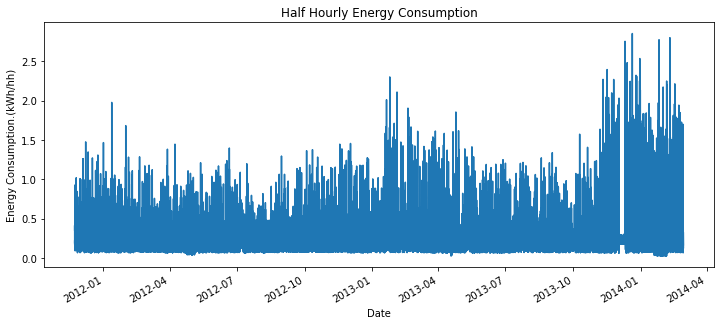

In [675]:
#MAC000145 plot
plot_houseID_hh(MAC000145_hh)

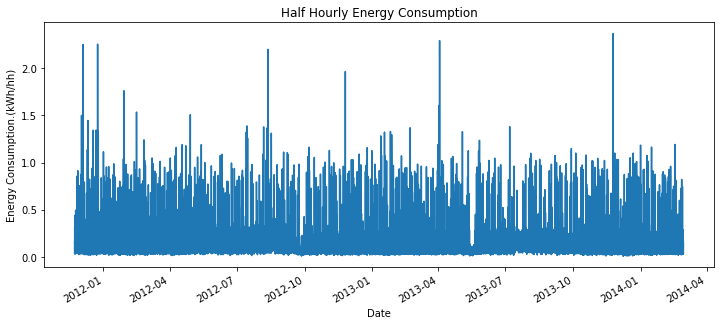

In [676]:
#MAC000147 plot.
plot_houseID_hh(MAC000147_hh)

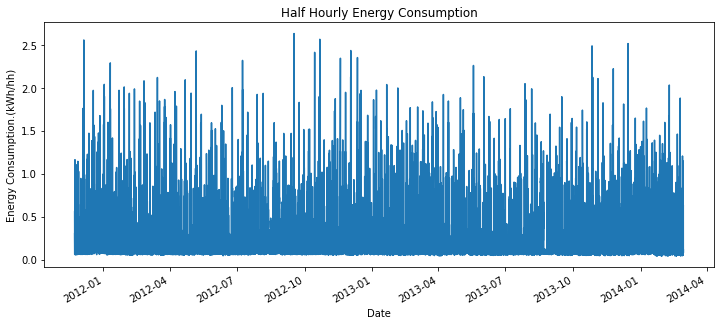

In [677]:
#MAC000150 plot.
plot_houseID_hh(MAC000150_hh)

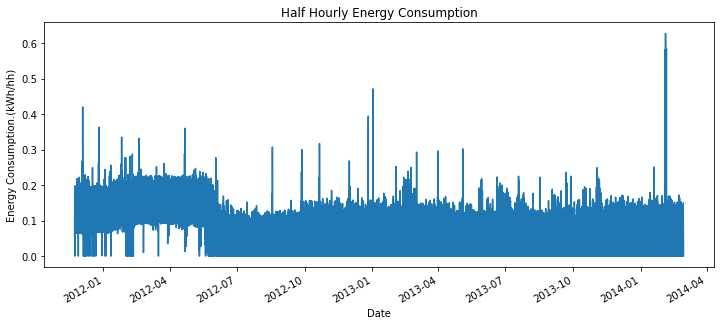

In [348]:
#MAC000149 plot.
plot_houseID_hh(MAC000149_hh)

In [930]:
#function for generating the X and y
#for window_size=3¢
# [[[1], [2], [3]]] [4]
# [[[2], [3], [4]]] [5]
# [[[3], [4], [5]]] [6]


def X_y_df(df, window_size=3):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [931]:
#assigning number of window size
WINDOW_SIZE = 3

#generating the 
X_149, y_149 = X_y_df(MAC000149_hh, WINDOW_SIZE)
X_147, y_147 = X_y_df(MAC000147_hh, WINDOW_SIZE)
X_145, y_145 = X_y_df(MAC000145_hh, WINDOW_SIZE)
X_150, y_150 = X_y_df(MAC000150_hh, WINDOW_SIZE)
X_151, y_151 = X_y_df(MAC000151_hh, WINDOW_SIZE)
X_152, y_152 = X_y_df(MAC000152_hh, WINDOW_SIZE)
X_153, y_153 = X_y_df(MAC000153_hh, WINDOW_SIZE)
X_155, y_155 = X_y_df(MAC000155_hh, WINDOW_SIZE)
X_156, y_156 = X_y_df(MAC000156_hh, WINDOW_SIZE)
X_157, y_157 = X_y_df(MAC000157_hh, WINDOW_SIZE)



In [969]:
#Function of generating xtrain,ytrain and validation sets.
def train_test_val_set(X,y):
    X_train, y_train = X[:20000], y[:20000]
    X_val, y_val = X[20000:27000], y[20000:27000]
    X_test, y_test = X[27000:], y[27000:]
    return X_train,y_train,X_val,y_val,X_test,y_test


In [970]:
#Assigning their training, validation and test sets.
X_train149,y_train149,X_val149,y_val149,X_test149,y_test149 = train_test_val_set(X_149,y_149)
X_train147,y_train147,X_val147,y_val147,X_test147,y_test147 = train_test_val_set(X_147,y_147)
X_train145,y_train145,X_val145,y_val145,X_test145,y_test145 = train_test_val_set(X_145,y_145)
X_train150,y_train150,X_val150,y_val150,X_test150,y_test150 = train_test_val_set(X_150,y_150)
X_train151,y_train151,X_val151,y_val151,X_test151,y_test151 = train_test_val_set(X_151,y_151)
X_train152,y_train152,X_val152,y_val152,X_test152,y_test152 = train_test_val_set(X_152,y_152)
X_train153,y_train153,X_val153,y_val153,X_test153,y_test153 = train_test_val_set(X_153,y_153)
X_train155,y_train155,X_val155,y_val155,X_test155,y_test155 = train_test_val_set(X_155,y_155)
X_train156,y_train156,X_val156,y_val156,X_test156,y_test156 = train_test_val_set(X_156,y_156)
X_train157,y_train157,X_val157,y_val157,X_test157,y_test157 = train_test_val_set(X_157,y_157)

In [971]:
#Checking shapes of a random house.
X_train151.shape,y_train151.shape,X_val151.shape,y_val151.shape,X_test151.shape,y_test151.shape

((20000, 3, 1), (20000,), (7000, 3, 1), (7000,), (12707, 3, 1), (12707,))

In [972]:
#Defining the LSTM model.
LSTM_model = Sequential()
LSTM_model.add(InputLayer((3, 1)))
LSTM_model.add(LSTM(64))
LSTM_model.add(Dense(8, 'relu'))
LSTM_model.add(Dense(1, 'linear'))

LSTM_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 64)                16896     
                                                                 
 dense_56 (Dense)            (None, 8)                 520       
                                                                 
 dense_57 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [978]:
#Fitting the data to the model.
def LSTM_fitting(model,xtrain,ytrain, xval,yval):
    check_point = ModelCheckpoint('LSTM_model/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
    model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=10, callbacks=[check_point])
    model = load_model('LSTM_model/')
    

In [974]:
#Function for plotting LSTM predictions vs Actual.
def LSTM_plot(pred, test, LCLid= ""):
    plt.plot(test, label= 'Actual')
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(pred, label = "LSTM   Predictions")
    plt.title("LSTM Predictions Plot for {}".format(LCLid))
    plt.ylabel("Energy Consumption(kWh/hh).")
    plt.xlabel("Half Hourly")
    plt.legend(loc= "upper left")
    plt.grid()
    plt.show()

### MAC000145

In [979]:
#Fitting MAC000145 into the model.
LSTM_fitting(LSTM_model,X_train145,y_train145, X_val145,y_val145)

Epoch 1/10
611/625 [============================>.] - ETA: 0s - loss: 0.0163 - root_mean_squared_error: 0.1278

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 7s 9ms/step - loss: 0.0164 - root_mean_squared_error: 0.1280 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1836
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1880
Epoch 3/10
624/625 [============================>.] - ETA: 0s - loss: 0.0164 - root_mean_squared_error: 0.1282

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1808
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1904
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1840
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1909
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0164 - root_mean_squared_error: 0.1280 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1833
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0348 - val_root_mean_s

In [980]:
#Prediction.
LSTM_pred_145 = LSTM_model.predict(X_test145).flatten()
LSTM_pred_145_results = pd.DataFrame(data={'Test Predictions':LSTM_pred_145, 'Actuals':y_test145})
LSTM_pred_145_results

Test Predictions  Actuals
0              0.175888    0.150
1              0.165293    0.216
2              0.236661    0.121
3              0.144918    0.114
4              0.162238    0.164
...                 ...      ...
12716          0.250071    0.184
12717          0.214617    0.327
12718          0.332784    0.163
12719          0.186041    0.122
12720          0.157077    0.167

[12721 rows x 2 columns]

In [981]:
metric_calculation(LSTM_pred_145,y_test145)

(0.2319838138218195, 0.05381649, 0.114548735, '11.45%')

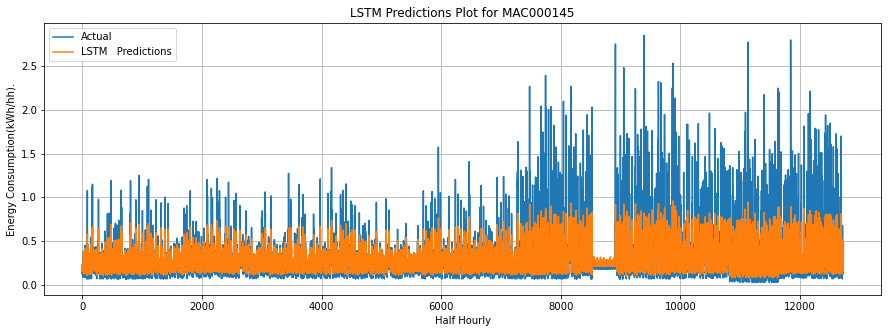

In [982]:
#Plotting.
LSTM_plot(LSTM_pred_145, y_test145, LCLid= "MAC000145")


### MAC000147

In [983]:
#Fitting the model.
LSTM_fitting(LSTM_model,X_train147,y_train147, X_val147,y_val147)

Epoch 1/10
603/625 [===========================>..] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.1148

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 6s 8ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 3/10
620/625 [============================>.] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.1141

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 5s 7ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 6/10
607/625 [============================>.] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.1138

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0130 - root_mean_squared_error: 0.1138 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 7/10
624/625 [============================>.] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.1141

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 8/10
606/625 [============================>.] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.1139

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 5s 8ms/step - loss: 0.0129 - root_mean_squared_error: 0.1137 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0129 - root_mean_squared_error: 0.1135 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 10/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087


In [984]:
#Prediction.
LSTM_pred_147 = LSTM_model.predict(X_test147).flatten()
LSTM_pred_147_results = pd.DataFrame(data={'Test Predictions':LSTM_pred_147, 'Actuals':y_test147})
LSTM_pred_147_results

Test Predictions  Actuals
0              0.078286    0.085
1              0.078286    0.048
2              0.078286    0.093
3              0.078286    0.038
4              0.078286    0.089
...                 ...      ...
12716          0.159580    0.154
12717          0.153286    0.168
12718          0.168279    0.142
12719          0.153556    0.033
12720          0.078286    0.048

[12721 rows x 2 columns]

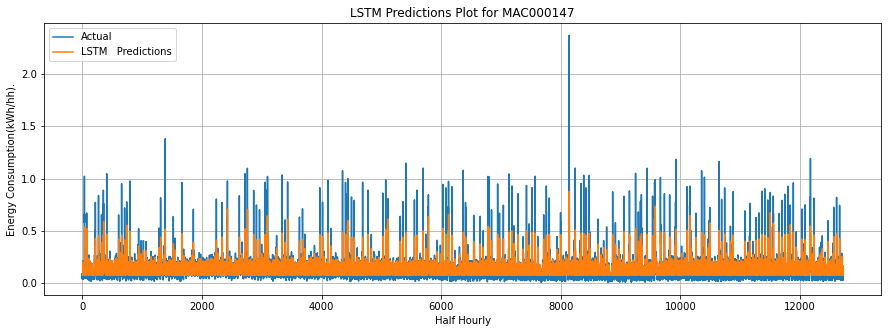

In [985]:
LSTM_plot(LSTM_pred_147, y_test147, LCLid= "MAC000147")

### MAC000149

In [986]:
LSTM_fitting(LSTM_model,X_train149,y_train149, X_val147,y_val149)

Epoch 1/10
610/625 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0335

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 6s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 2/10
621/625 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0329

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 6/10
607/625 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0326

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 5s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0750
Epoch 7/10
614/625 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0325

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 5s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 10/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737


In [987]:
LSTM_pred_149 = LSTM_model.predict(X_test149).flatten()
LSTM_pred_149_results = pd.DataFrame(data={'Test Predictions':LSTM_pred_149, 'Actuals':y_test149})
LSTM_pred_149_results

Test Predictions  Actuals
0             0.034998    0.091
1             0.064126    0.060
2             0.057905    0.041
3             0.051153    0.043
4             0.045170    0.056
...                ...      ...
6687          0.101968    0.072
6688          0.079131    0.094
6689          0.090252    0.072
6690          0.078363    0.083
6691          0.083388    0.051

[6692 rows x 2 columns]

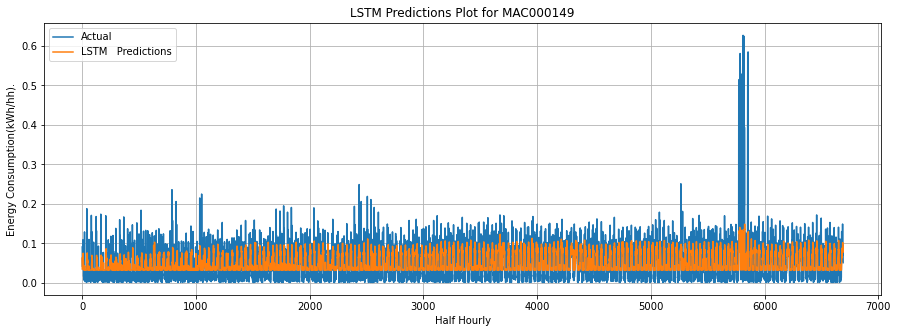

In [988]:
LSTM_plot(LSTM_pred_149, y_test149, LCLid= "MAC000149")

### MAC000150

In [989]:
LSTM_fitting(LSTM_model,X_train150,y_train150, X_val147,y_val150)

Epoch 1/10
612/625 [============================>.] - ETA: 0s - loss: 0.0344 - root_mean_squared_error: 0.1854

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 6s 8ms/step - loss: 0.0342 - root_mean_squared_error: 0.1848 - val_loss: 0.0599 - val_root_mean_squared_error: 0.2447
Epoch 2/10
622/625 [============================>.] - ETA: 0s - loss: 0.0313 - root_mean_squared_error: 0.1770

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0315 - root_mean_squared_error: 0.1774 - val_loss: 0.0544 - val_root_mean_squared_error: 0.2332
Epoch 3/10
612/625 [============================>.] - ETA: 0s - loss: 0.0314 - root_mean_squared_error: 0.1771

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 5s 8ms/step - loss: 0.0312 - root_mean_squared_error: 0.1766 - val_loss: 0.0522 - val_root_mean_squared_error: 0.2285
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0313 - root_mean_squared_error: 0.1770 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2386
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0312 - root_mean_squared_error: 0.1766 - val_loss: 0.0588 - val_root_mean_squared_error: 0.2424
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0309 - root_mean_squared_error: 0.1759 - val_loss: 0.0552 - val_root_mean_squared_error: 0.2350
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0310 - root_mean_squared_error: 0.1762 - val_loss: 0.0555 - val_root_mean_squared_error: 0.2356
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0309 - root_mean_squared_error: 0.1759 - val_loss: 0.0539 - val_root_mean_s

In [990]:
#prediction
LSTM_pred_150 = LSTM_model.predict(X_test150).flatten()
LSTM_pred_150_results = pd.DataFrame(data={'Test Predictions':LSTM_pred_150, 'Actuals':y_test150})
LSTM_pred_150_results

Test Predictions  Actuals
0              0.157687    0.189
1              0.163648    0.183
2              0.161566    0.163
3              0.149382    0.102
4              0.099259    0.086
...                 ...      ...
12711          0.373871    0.631
12712          0.467258    0.178
12713          0.205875    0.108
12714          0.138415    0.078
12715          0.063262    0.113

[12716 rows x 2 columns]

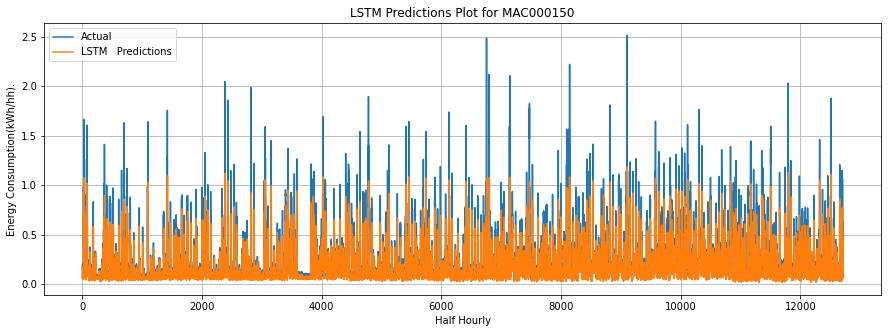

In [991]:
LSTM_plot(LSTM_pred_150, y_test150, LCLid= "MAC000150")

### MAC000151

In [992]:
LSTM_fitting(LSTM_model,X_train151,y_train151, X_val151,y_val151)

Epoch 1/10
617/625 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0452

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 6s 9ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 3/10
603/625 [===========================>..] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0448

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 4/10
604/625 [===========================>..] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0443

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 9/10
624/625 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0443

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 5s 8ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 10/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478


In [993]:
#prediction
LSTM_pred_151 = LSTM_model.predict(X_test151).flatten()
LSTM_pred_151_results = pd.DataFrame(data={'Test Predictions':LSTM_pred_151, 'Actuals':y_test151})
LSTM_pred_151_results

Test Predictions  Actuals
0              0.120590    0.110
1              0.119403    0.083
2              0.095504    0.050
3              0.068384    0.042
4              0.065875    0.050
...                 ...      ...
12702          0.130602    0.097
12703          0.101331    0.065
12704          0.079822    0.026
12705          0.044303    0.024
12706          0.051120    0.026

[12707 rows x 2 columns]

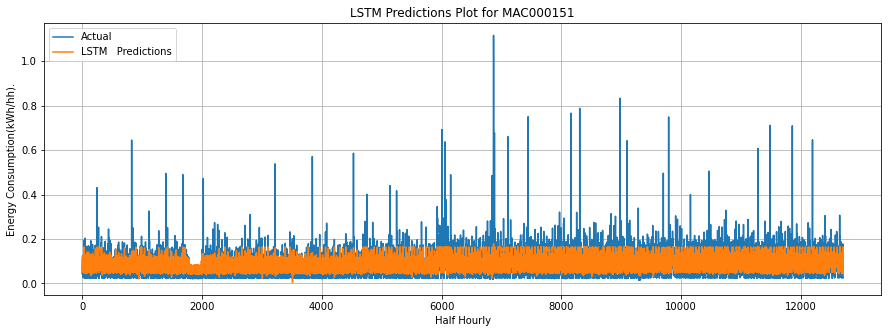

In [994]:
LSTM_plot(LSTM_pred_151, y_test151, LCLid= "MAC000151")

### MAC000152

In [995]:
LSTM_fitting(LSTM_model,X_train152,y_train152, X_val152,y_val152)

Epoch 1/10
621/625 [============================>.] - ETA: 0s - loss: 0.0276 - root_mean_squared_error: 0.1661

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 6s 7ms/step - loss: 0.0276 - root_mean_squared_error: 0.1660 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1867
Epoch 2/10
618/625 [============================>.] - ETA: 0s - loss: 0.0265 - root_mean_squared_error: 0.1627

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 5s 8ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1865
Epoch 3/10
612/625 [============================>.] - ETA: 0s - loss: 0.0265 - root_mean_squared_error: 0.1629

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0265 - root_mean_squared_error: 0.1628 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1812
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1821
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0263 - root_mean_squared_error: 0.1622 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1851
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0263 - root_mean_squared_error: 0.1623 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1856
Epoch 8/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0263 - root_mean_squared_error: 0.1622 - val_loss: 0.0338 - val_root_mean_s

In [996]:
#prediction
LSTM_pred_152 = LSTM_model.predict(X_test152).flatten()
LSTM_pred_152_results = pd.DataFrame(data={'Test Predictions':LSTM_pred_152, 'Actuals':y_test152})
LSTM_pred_152_results

Test Predictions  Actuals
0              0.110935    0.117
1              0.119323    0.091
2              0.093151    0.089
3              0.109237    0.034
4              0.041288    0.034
...                 ...      ...
12710          0.232437    0.243
12711          0.286042    0.171
12712          0.202267    0.132
12713          0.168661    0.126
12714          0.147954    0.123

[12715 rows x 2 columns]

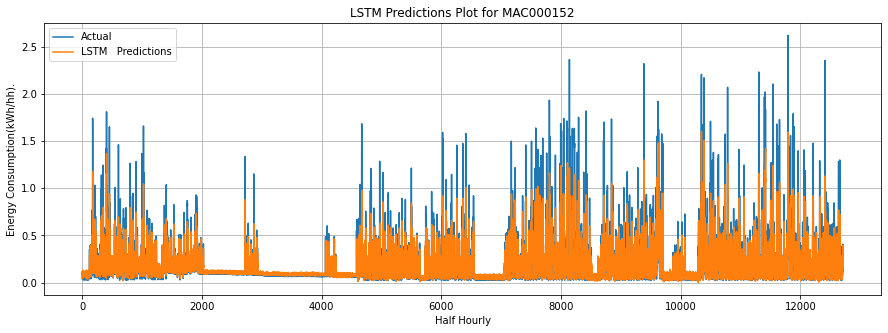

In [997]:
LSTM_plot(LSTM_pred_152, y_test152, LCLid= "MAC000152")

### MAC000153

In [998]:
#LSTM model Fitting
LSTM_fitting(LSTM_model,X_train153,y_train153, X_val153,y_val153)

Epoch 1/10
612/625 [============================>.] - ETA: 0s - loss: 0.1562 - root_mean_squared_error: 0.3952

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 6s 8ms/step - loss: 0.1560 - root_mean_squared_error: 0.3950 - val_loss: 0.1672 - val_root_mean_squared_error: 0.4089
Epoch 2/10
618/625 [============================>.] - ETA: 0s - loss: 0.1491 - root_mean_squared_error: 0.3861

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.1489 - root_mean_squared_error: 0.3859 - val_loss: 0.1638 - val_root_mean_squared_error: 0.4047
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1469 - root_mean_squared_error: 0.3832 - val_loss: 0.1668 - val_root_mean_squared_error: 0.4084
Epoch 4/10
612/625 [============================>.] - ETA: 0s - loss: 0.1449 - root_mean_squared_error: 0.3806

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 5s 7ms/step - loss: 0.1463 - root_mean_squared_error: 0.3825 - val_loss: 0.1626 - val_root_mean_squared_error: 0.4032
Epoch 5/10
612/625 [============================>.] - ETA: 0s - loss: 0.1454 - root_mean_squared_error: 0.3813

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.1455 - root_mean_squared_error: 0.3814 - val_loss: 0.1621 - val_root_mean_squared_error: 0.4026
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1446 - root_mean_squared_error: 0.3802 - val_loss: 0.1639 - val_root_mean_squared_error: 0.4049
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1443 - root_mean_squared_error: 0.3799 - val_loss: 0.1738 - val_root_mean_squared_error: 0.4169
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1443 - root_mean_squared_error: 0.3799 - val_loss: 0.1657 - val_root_mean_squared_error: 0.4071
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1438 - root_mean_squared_error: 0.3793 - val_loss: 0.1648 - val_root_mean_squared_error: 0.4060
Epoch 10/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1438 - root_mean_squared_error: 0.3792 - val_loss: 0.1725 - val_root_mean_

In [999]:
#prediction
LSTM_pred_153 = LSTM_model.predict(X_test153).flatten()
LSTM_pred_153_results = pd.DataFrame(data={'Test Predictions':LSTM_pred_153, 'Actuals':y_test153})
LSTM_pred_153_results

Test Predictions  Actuals
0              0.192810    0.148
1              0.245701    0.129
2              0.244442    0.147
3              0.258991    0.450
4              0.404630    0.545
...                 ...      ...
12705          0.546589    0.567
12706          0.591221    0.695
12707          0.658176    0.807
12708          0.756579    0.308
12709          0.421764    2.249

[12710 rows x 2 columns]

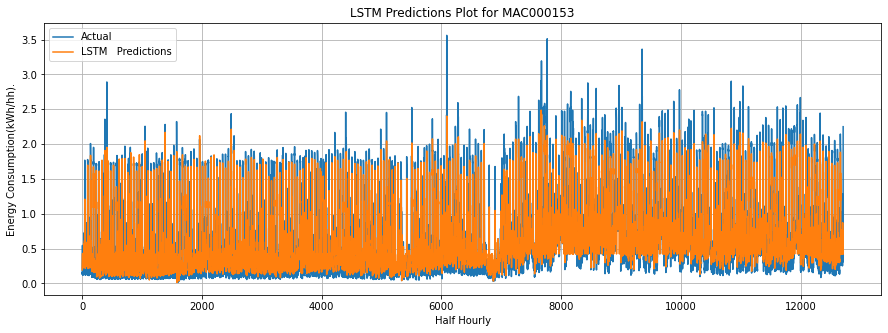

In [1000]:
#Plotting
LSTM_plot(LSTM_pred_153, y_test153, LCLid= "MAC000153")

### MAC000155

In [1001]:
#LSTM model Fitting.
LSTM_fitting(LSTM_model,X_train155,y_train155, X_val155,y_val155)

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.1294

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 6s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.1294 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1863
Epoch 2/10
618/625 [============================>.] - ETA: 0s - loss: 0.0165 - root_mean_squared_error: 0.1286

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1841
Epoch 3/10
618/625 [============================>.] - ETA: 0s - loss: 0.0164 - root_mean_squared_error: 0.1281

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0164 - root_mean_squared_error: 0.1281 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1826
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1905
Epoch 5/10
615/625 [============================>.] - ETA: 0s - loss: 0.0162 - root_mean_squared_error: 0.1275

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 5s 7ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1794
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0164 - root_mean_squared_error: 0.1280 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1858
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1816
Epoch 8/10
618/625 [============================>.] - ETA: 0s - loss: 0.0163 - root_mean_squared_error: 0.1275

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1773
Epoch 9/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1886
Epoch 10/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0162 - root_mean_squared_error: 0.1275 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1806


In [1002]:
#prediction
LSTM_pred_155 = LSTM_model.predict(X_test155).flatten()
LSTM_pred_155_results = pd.DataFrame(data={'Test Predictions':LSTM_pred_155, 'Actuals':y_test155})
LSTM_pred_155_results

Test Predictions  Actuals
0              0.176766    0.150
1              0.192718    0.216
2              0.243560    0.121
3              0.141595    0.114
4              0.176413    0.164
...                 ...      ...
12716          0.257902    0.184
12717          0.220691    0.327
12718          0.344538    0.163
12719          0.179059    0.122
12720          0.169337    0.167

[12721 rows x 2 columns]

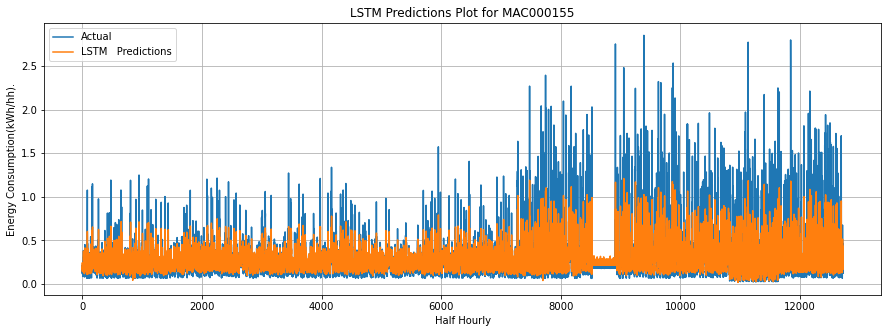

In [1003]:
#Plotting
LSTM_plot(LSTM_pred_155, y_test155, LCLid= "MAC000155")


### MAC000156

In [1004]:
#LSTM Model fitting.
LSTM_fitting(LSTM_model,X_train156,y_train156, X_val156,y_val156)

Epoch 1/10
621/625 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1065

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 7s 8ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1165
Epoch 2/10
614/625 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1054

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0112 - root_mean_squared_error: 0.1058 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0111 - root_mean_squared_error: 0.1055 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1168
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0111 - root_mean_squared_error: 0.1056 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 6/10
607/625 [============================>.] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.1050

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0111 - root_mean_squared_error: 0.1054 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1051 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1050 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1050 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 10/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161


In [1005]:
#prediction
LSTM_pred_156 = LSTM_model.predict(X_test156).flatten()
LSTM_pred_156_results = pd.DataFrame(data={'Test Predictions':LSTM_pred_156, 'Actuals':y_test156})
LSTM_pred_156_results

Test Predictions  Actuals
0              0.153122    0.138
1              0.166687    0.135
2              0.164571    0.131
3              0.156933    0.138
4              0.167312    0.133
...                 ...      ...
12704          0.207869    0.192
12705          0.236134    0.166
12706          0.211731    0.171
12707          0.211886    0.168
12708          0.211074    0.161

[12709 rows x 2 columns]

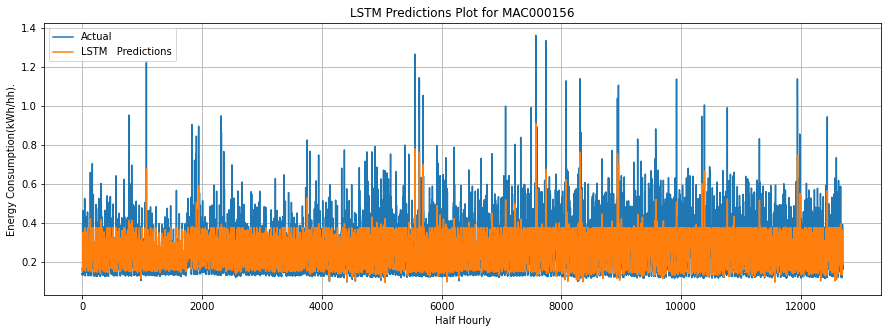

In [1006]:
#Plotting
LSTM_plot(LSTM_pred_156, y_test156, LCLid= "MAC000156")

### MAC000157

In [1007]:
#LSTM Model fitting.
LSTM_fitting(LSTM_model,X_train157,y_train157, X_val157,y_val157)

Epoch 1/10
613/625 [============================>.] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.1070

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 6s 7ms/step - loss: 0.0114 - root_mean_squared_error: 0.1069 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0112 - root_mean_squared_error: 0.1061 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1051 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 4/10
619/625 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1053

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 4s 7ms/step - loss: 0.0111 - root_mean_squared_error: 0.1054 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0111 - root_mean_squared_error: 0.1051 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 6/10
619/625 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1052

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


625/625 [==============================] - 5s 8ms/step - loss: 0.0111 - root_mean_squared_error: 0.1051 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0111 - root_mean_squared_error: 0.1051 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 9/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0110 - root_mean_squared_error: 0.1050 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 10/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132


In [1008]:
#prediction
LSTM_pred_157 = LSTM_model.predict(X_test157).flatten()
LSTM_pred_157_results = pd.DataFrame(data={'Test Predictions':LSTM_pred_157, 'Actuals':y_test157})
LSTM_pred_157_results

Test Predictions  Actuals
0              0.200293    0.187
1              0.218118    0.180
2              0.188196    0.179
3              0.188334    0.208
4              0.218074    0.386
...                 ...      ...
12683          0.409612    0.396
12684          0.329244    0.264
12685          0.267263    0.264
12686          0.284957    0.330
12687          0.312021    0.213

[12688 rows x 2 columns]

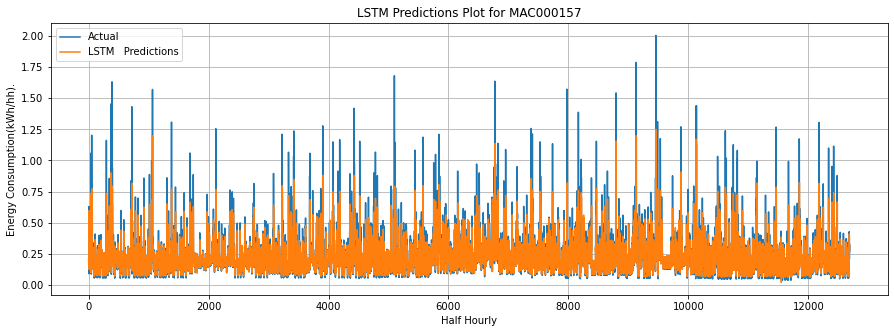

In [1009]:
#Plotting
LSTM_plot(LSTM_pred_157, y_test157, LCLid= "MAC000157")

## Final Results of  all 10 houses

In [1010]:
#FOR MAC000145
MAC000145_results_LSTM = metric_calculation(LSTM_pred_145,y_test145)
house_145['LSTM'] = MAC000145_results_LSTM
house_145

Linear Regression Random Forest MLP Regressor XGBoost Regressor  \
RMSE         0.0134649      0.387464      0.138777          0.210962   
MSE        0.000181304       40.3155       39.3234           39.4187   
MAE          0.0117008      0.127463      0.105781           0.12551   
MAPE             1.17%        12.75%        10.58%            12.55%   

           LSTM  
RMSE   0.231984  
MSE   0.0538165  
MAE    0.114549  
MAPE     11.45%

In [1011]:
#FOR MAC000147
MAC000147_results_LSTM = metric_calculation(LSTM_pred_147,y_test147)
house_147['LSTM'] = MAC000147_results_LSTM
house_147

Linear Regression Random Forest MLP Regressor XGBoost Regressor  \
RMSE        0.00462798      0.132543     0.0917284         0.0987748   
MSE        2.14182e-05       5.09546       5.16655            5.1377   
MAE         0.00427525     0.0252363      0.072229         0.0228488   
MAPE             0.43%         2.52%         7.22%             2.28%   

            LSTM  
RMSE   0.0983015  
MSE   0.00966318  
MAE    0.0495138  
MAPE       4.95%

In [1012]:
#FOR MAC000149
MAC000149_results_LSTM = metric_calculation(LSTM_pred_149,y_test149)
house_149['LSTM'] = MAC000149_results_LSTM
house_149

Linear Regression Random Forest MLP Regressor XGBoost Regressor  \
RMSE         0.0106436       0.71063      0.215997           0.70456   
MSE        0.000113286       2.21716       2.98103           2.22254   
MAE          0.0103765     0.0956056     0.0512504         0.0966594   
MAPE             1.04%         9.56%         5.13%             9.67%   

            LSTM  
RMSE   0.0453999  
MSE   0.00206115  
MAE    0.0258671  
MAPE       2.59%

In [1013]:
#FOR MAC000150
MAC000150_results_LSTM = metric_calculation(LSTM_pred_150,y_test150)
house_150['LSTM'] = MAC000150_results_LSTM
house_150

Linear Regression Random Forest MLP Regressor XGBoost Regressor  \
RMSE         0.0350495     0.0469286     0.0995988         0.0508646   
MSE         0.00122847       19.9857       19.8095           20.0995   
MAE         0.00797303     0.0178673      0.080271         0.0291056   
MAPE              0.8%         1.79%         8.03%             2.91%   

           LSTM  
RMSE   0.172244  
MSE   0.0296681  
MAE   0.0862268  
MAPE      8.62%

In [1014]:
#FOR MAC000151
MAC000151_results_LSTM = metric_calculation(LSTM_pred_151,y_test151)
house_151['LSTM'] = MAC000151_results_LSTM
house_151

Linear Regression Random Forest MLP Regressor XGBoost Regressor  \
RMSE        0.00973448      0.025299      0.254433         0.0155829   
MSE        9.47602e-05      0.463761      0.479731          0.465852   
MAE          0.0075436    0.00763522      0.197657        0.00746865   
MAPE             0.75%         0.76%        19.77%             0.75%   

            LSTM  
RMSE   0.0493519  
MSE   0.00243561  
MAE    0.0325291  
MAPE       3.25%

In [1015]:
#FOR MAC000152
MAC000152_results_LSTM = metric_calculation(LSTM_pred_152,y_test152)
house_152['LSTM'] = MAC000152_results_LSTM
house_152

Linear Regression Random Forest MLP Regressor XGBoost Regressor  \
RMSE        0.00914626      0.984214      0.547931          0.820606   
MSE        8.36541e-05       66.7198       68.6816           67.9219   
MAE         0.00627255      0.125941      0.133532          0.130474   
MAPE             0.63%        12.59%        13.35%            13.05%   

           LSTM  
RMSE   0.179771  
MSE   0.0323176  
MAE   0.0882142  
MAPE      8.82%

In [1016]:
#FOR MAC000153
MAC000153_results_LSTM = metric_calculation(LSTM_pred_153,y_test153)
house_153['LSTM'] = MAC000153_results_LSTM
house_153

Linear Regression Random Forest MLP Regressor XGBoost Regressor      LSTM
RMSE         0.0715083     0.0749467       0.09742           0.15354  0.357685
MSE         0.00511344       74.0175       73.6482           73.8071  0.127938
MAE          0.0445266     0.0452025     0.0693491          0.112224  0.221234
MAPE             4.45%         4.52%         6.93%            11.22%    22.12%

In [1017]:
#FOR MAC000155
MAC000155_results_LSTM = metric_calculation(LSTM_pred_155,y_test155)
house_155['LSTM'] = MAC000155_results_LSTM
house_155

Linear Regression Random Forest MLP Regressor XGBoost Regressor  \
RMSE          0.041578      0.139421      0.204571          0.087915   
MSE         0.00172873       16.1851       15.7984           16.2714   
MAE          0.0165593     0.0516363      0.155188         0.0539321   
MAPE             1.66%         5.16%        15.52%             5.39%   

           LSTM  
RMSE    0.23228  
MSE   0.0539538  
MAE    0.117118  
MAPE     11.71%

In [1018]:
#FOR MAC000156
MAC000156_results_LSTM = metric_calculation(LSTM_pred_156,y_test156)
house_156['LSTM'] = MAC000156_results_LSTM
house_156

Linear Regression Random Forest MLP Regressor XGBoost Regressor  \
RMSE         0.0385353      0.085024      0.434824         0.0442335   
MSE         0.00148497       2.89083       2.68909           2.93544   
MAE          0.0111439     0.0227358      0.364385           0.01859   
MAPE             1.11%         2.27%        36.44%             1.86%   

           LSTM  
RMSE   0.101979  
MSE   0.0103996  
MAE   0.0705117  
MAPE      7.05%

In [1019]:
#FOR MAC000157
MAC000157_results_LSTM = metric_calculation(LSTM_pred_157,y_test157)
house_157['LSTM'] = MAC000157_results_LSTM
house_157

Linear Regression Random Forest MLP Regressor XGBoost Regressor  \
RMSE         0.0166066       0.22182      0.099234         0.0601434   
MSE        0.000275781        14.866       14.8385           14.9956   
MAE         0.00507612     0.0446113     0.0813281         0.0321311   
MAPE             0.51%         4.46%         8.13%             3.21%   

           LSTM  
RMSE    0.11002  
MSE   0.0121043  
MAE   0.0538662  
MAPE      5.39%